In [2]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from collections import defaultdict
import argparse
import sys
import gzip
import operator
from scipy import stats
import pandas as pd

import scipy as sp
import json
from sklearn.metrics import normalized_mutual_info_score
import community
import datetime as dt

from network_ei import *
from causal_emergence import *
from get_motifs import *

import matplotlib.patches as mpatches
from matplotlib import gridspec
from matplotlib._png import read_png
from matplotlib.offsetbox import AnnotationBbox, OffsetImage

%matplotlib inline

# Causal Structure as a Network: Quantifying Certainty in Complex Systems

# Chapter 08: Effective Information Differences in Real Networks

Null models and real networks

In [119]:
# smaller_than = 1900

In [3]:
def get_chunksize_dict(N, size_dist):
    """Returns an array of size_dist-distributed chunks for your network"""
    print(size_dist)
    chunksize_dist = np.array(size_dist)
    chunksize_dist = sorted(chunksize_dist, reverse=True)
    chunksizes = np.array(N*(chunksize_dist/sum(chunksize_dist)), dtype=int)
    diff_size_check = int(N - sum(chunksizes))
    if diff_size_check > 0:
        for i in range(diff_size_check):
            chunksizes[0] += 1
    if diff_size_check < 0:
        for i in range(np.abs(diff_size_check)):
            chunksizes[0] -= 1

    for i in range(len(chunksizes)):
        if chunksizes[i] == 0:
            chunksizes[0] -= 2
            chunksizes[i] += 2

        if chunksizes[i] == 1:
            chunksizes[0] -= 1
            chunksizes[i] += 1    

    chunk_dict = {}
    curr = 0
    for i in range(len(chunksizes)):
        nums = list(range(curr, curr+chunksizes[i]))
        chunk_dict[i] = nums
        curr = nums[-1]+1
    
    node_chunks_dict = {}
    for k in chunk_dict.keys():
        for i in chunk_dict[k]:
            node_chunks_dict[i] = k
    
    return chunk_dict, node_chunks_dict

def get_pos(N, size_dist):
    """Arranges the graphs nicely"""
    pos = {}
    chunk_dict, node_chunk_dict = get_chunksize_dict(N, size_dist)
    ii = 0
    for chunk, nodes in chunk_dict.items():
        G = nx.complete_graph(len(nodes))
        posi = nx.spring_layout(G)
        posi = dict(zip(nodes, np.array(list(posi.values())) + np.array([3*ii,0])))
        pos.update(posi)
        ii += 1
                
    return pos

def random_twocluster_network(N, Nr, p_in, selfloops=False):
    """
    Creates a quasi-SBM structure.
    """
    p_ex = 1-p_in
    sizes = [N-Nr, Nr]
    macros = [0]*sizes[0] + [1]*sizes[1]
    
    G = nx.DiGraph()
    G.add_nodes_from(list(range(sum(sizes))))
    nx.set_node_attributes(G, dict(zip(G.nodes(),list(np.array(macros)+N))), 'macro')

    probs = [p_in]*sizes[0] + [p_ex]*sizes[1]
    for node_i in list(G.nodes())[:sizes[0]]:
        for node_j in list(G.nodes()):
            if selfloops:
                if np.random.rand() < probs[node_j]:# and node_i!=node_j:
                    G.add_edge(node_i, node_j)
                    G.add_edge(node_j, node_i)

            else:
                if np.random.rand() < probs[node_j] and node_i!=node_j:
                    G.add_edge(node_i, node_j)
                
    probs = [p_ex]*sizes[0] + [p_in]*sizes[1]
    for node_i in list(G.nodes())[sizes[0]:]:
        for node_j in list(G.nodes()):
            if selfloops:
                if np.random.rand() < probs[node_j]:# and node_i!=node_j:
                    G.add_edge(node_i, node_j)
                    G.add_edge(node_j, node_i)

            else:
                if np.random.rand() < probs[node_j] and node_i!=node_j:
                    G.add_edge(node_i, node_j)

    
    return G

def get_effect_info_i(W_out, W_in, i, p0=np.exp(-20)):
    "Calculates effect information for each node in a given network."
    N_out = W_out.shape[0]
    W_outi = W_out[i]
#     if 0.0 in W_in:
#         print(W_in)
    if sum(W_outi) > 0:
#     if N_out > 0 and sum(W_outi)>0 and sum(sum(W_out))>0:
#     if N_out > 0 and sum(sum(W_out))>0:
        return sp.stats.entropy(W_outi, W_in, base=2)
    else:
        return 0.0

def causal_emergence_s(G, p0=0, thresh=0.000001, printt=True, ntimes=-1, p_thresh=0.2):
    """
    Given a micro-scale network, iterate through possible macro-groupings and look for causal emergence.
    - param G: a networkx object or adjacency matrix or TPM
    - param p0: smallest probability
    
    - output Gm: a macro-scale network object with higher EI than G
    """
    G = prepare_network(G, p0)
#     G = nx.convert_node_labels_to_integers(G)
    nodelist = G.nodes()
    current_ei = get_ei(G, p0)
    EI_G = current_ei

    micro_nodes_left = list(G.nodes())
    micros_that_have_been_macroed = []
    macro_mapping = dict(zip(micro_nodes_left, micro_nodes_left))    
    if printt:
        print("Starting with this tpm:\n",np.round(get_Wout_full(G,p0), 4))
        print("\nSearch started... current_ei = %.4f"%current_ei)
    micro_W_out = get_Wout_full(G,p0)
    micro_W_in  = get_Win(G,p0)
    N_micro = len(micro_nodes_left)

    change_in_ei_dict_max = {}
    change_in_ei_dict_mean = {}

    count = 0
    np.random.shuffle(micro_nodes_left)

    ##############
    if ntimes != -1 and ntimes < N_micro:
        micro_nodes_left = micro_nodes_left[:ntimes]
    ##############
    
    for node_i in micro_nodes_left:
        change_in_ei_dict = []
        effect_info_i = get_effect_info_i(micro_W_out, micro_W_in, node_i, p0)
        count += 1
        if printt:
            print("%03i"%count, "... %03i"%node_i,"...","macro size =",len(np.unique(list(macro_mapping.values()))))

        neighbors_i = set(list(G.successors(node_i))).union(set(list(G.predecessors(node_i))))
        for node_j in neighbors_i:
            neighbors_j = set(list(G.successors(node_j))).union(set(list(G.predecessors(node_j))))
            neighbors_i = neighbors_j.union(neighbors_i)
        
        ########## sample from the queue also
        macros_to_check = [i for i in list(neighbors_i) if i!=node_i]
        np.random.shuffle(macros_to_check)
        idx_m = int(p_thresh*len(macros_to_check))
        queue = macros_to_check[:idx_m]
        
        node_i_macro = macro_mapping[node_i]
        if node_i_macro == node_i:
            node_i_macro = max(list(macro_mapping.values()))+1
        
        has_been_checked = []
        while len(queue) > 0:
#             print(sorted(queue))
            np.random.shuffle(queue)
            possible_macro = queue.pop()
            has_been_checked.append(possible_macro)
            
            effect_info_j = get_effect_info_i(micro_W_out, micro_W_in, possible_macro, p0)
            ei_two_micros = np.mean([effect_info_i, effect_info_j])

            possible_mapping = macro_mapping.copy()
            possible_mapping[node_i]         = node_i_macro
            possible_mapping[possible_macro] = node_i_macro
            
            possible_mapping_dummy = dict(zip(nodelist, nodelist))
            possible_mapping_dummy[node_i] = N_micro; possible_mapping_dummy[possible_macro] = N_micro
#             possible_mapping_dummy = collections.OrderedDict(sorted(possible_mapping_dummy.items()))

            MACRO = get_macro(G, possible_mapping_dummy, p0)
            macro_W_in = get_Win(MACRO, p0)
            m_i = len(macro_W_in)-1
#             print("MACRO", node_i, possible_macro, possible_mapping_dummy)
            ei_one_macro = get_effect_info_i(MACRO, macro_W_in, m_i, p0)

            change_in_ei_dict.append(ei_one_macro - ei_two_micros)

            if ei_one_macro - ei_two_micros > thresh:
                macro_mapping = possible_mapping

#                 if printt:
#                     print("just found successful macro grouping... effect information \
#                           difference = %.4f"%(ei_one_macro - ei_two_micros))
                    
                micros_that_have_been_macroed.append(node_i)
                micros_that_have_been_macroed.append(possible_macro)
                micros_that_have_been_macroed = list(set(micros_that_have_been_macroed))

                nodes_in_macro_i = [k for k, v in macro_mapping.items() if v==node_i_macro]

#                 for new_micro_in_macro_i in nodes_in_macro_i:
#                     neighbors_Mi = set(list(
#                         G.successors(new_micro_in_macro_i))).\
#                         union(set(list(G.predecessors(new_micro_in_macro_i))))

#                     for node_Mj in neighbors_Mi:
#                         cond1 = node_Mj not in macros_to_check
#                         cond2 = node_Mj not in queue
#                         cond3 = node_Mj not in has_been_checked
#                         cond4 = node_Mj != node_i
#                         if cond1 and cond2 and cond3 and cond4:
#                             queue.append(node_Mj)

#             if np.random.rand() < 0.01:
#                 queue = []
                
        if change_in_ei_dict:
            change_in_ei_dict_mean[node_i] = np.mean(change_in_ei_dict)
            change_in_ei_dict_max[ node_i] =     max(change_in_ei_dict)

    nx.set_node_attributes(G, change_in_ei_dict_mean, 'mean_EI_change')
    nx.set_node_attributes(G, change_in_ei_dict_max,  'max_EI_change' )
    try:
        MACRO = get_macro(G, macro_mapping, p0)
        Gm = prepare_network(MACRO, p0=p0)
        return Gm, macro_mapping, G
    except:
        return [], macro_mapping, G

In [120]:
citation_dict = {'Name':["High Energy Physics - Phenomenology","High Energy Physics - Theory",
                         "Cora Citations", "DBLP Citations"], 
                 "Network":[], 
                 "Type":['citations','citations','citations','citations'],
                 "Newty":['information','information','information','information'],
                 "Filename":["../data/konect_data/citations/cit-HepPh/out.cit-HepPh", 
                             "../data/konect_data/citations/cit-HepTh/out.cit-HepTh",
                             "../data/konect_data/citations/subelj_cora/out.subelj_cora_cora",
                             "../data/konect_data/citations/dblp-cite/out.dblp-cite"]}

for fn in citation_dict['Filename']:
    with open(fn, 'rt') as f:
        print(fn)
        g = nx.parse_edgelist(f, comments='%', create_using=nx.DiGraph())
        citation_dict['Network'].append(g)
#         if g.number_of_nodes() < smaller_than:
#             citation_dict['Network'].append(g)
        
print()
for net in range(len(citation_dict['Network'])):
    print(citation_dict['Name'][net], "has",
          citation_dict['Network'][net].number_of_nodes(), "nodes and",
          citation_dict['Network'][net].number_of_edges(), "edges.")

../data/konect_data/citations/cit-HepPh/out.cit-HepPh
../data/konect_data/citations/cit-HepTh/out.cit-HepTh
../data/konect_data/citations/subelj_cora/out.subelj_cora_cora
../data/konect_data/citations/dblp-cite/out.dblp-cite

High Energy Physics - Phenomenology has 34546 nodes and 421578 edges.
High Energy Physics - Theory has 27770 nodes and 352807 edges.
Cora Citations has 23166 nodes and 91500 edges.
DBLP Citations has 12591 nodes and 49743 edges.


In [144]:
test = hyperlin_dict['Network'][0]
test = nx.convert_node_labels_to_integers(test)
N = test.number_of_nodes()

p_thresh = 0.10
p_nodes  = 0.01
ntimes   = int(N*p_nodes)

thresh = 0.0001
p0 = 0

In [145]:
print("Starting causal emergence function at", dt.datetime.now())
_, _, test = causal_emergence_s(test, p0, thresh, True, ntimes, p_thresh)
print("Ending causal emergence function at", dt.datetime.now())

Starting causal emergence function at 2018-12-10 19:53:03.734342
Starting with this tpm:
 [[0.     0.0667 0.0667 ... 0.     0.     0.    ]
 [0.     0.     0.0345 ... 0.     0.     0.    ]
 [0.     0.0115 0.     ... 0.     0.     0.    ]
 ...
 [0.     0.     0.     ... 0.     0.     0.    ]
 [0.     0.     0.     ... 0.     0.     0.    ]
 [0.     0.     0.     ... 0.     0.     0.    ]]

Search started... current_ei = 5.0076
001 ... 044 ... macro size = 1224


/Users/brennan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:193: RuntimeWarning: invalid value encountered in true_divide


002 ... 270 ... macro size = 1221
003 ... 1046 ... macro size = 1221
004 ... 556 ... macro size = 1212
005 ... 800 ... macro size = 1209
006 ... 1014 ... macro size = 1205
007 ... 075 ... macro size = 1200
008 ... 282 ... macro size = 1197
009 ... 002 ... macro size = 1194
010 ... 1126 ... macro size = 1186
011 ... 879 ... macro size = 1186
012 ... 507 ... macro size = 1186
Ending causal emergence function at 2018-12-10 20:05:33.464010


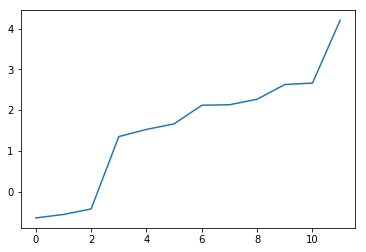

In [149]:
plt.plot(sorted(nx.get_node_attributes(test, "max_EI_change").values()))

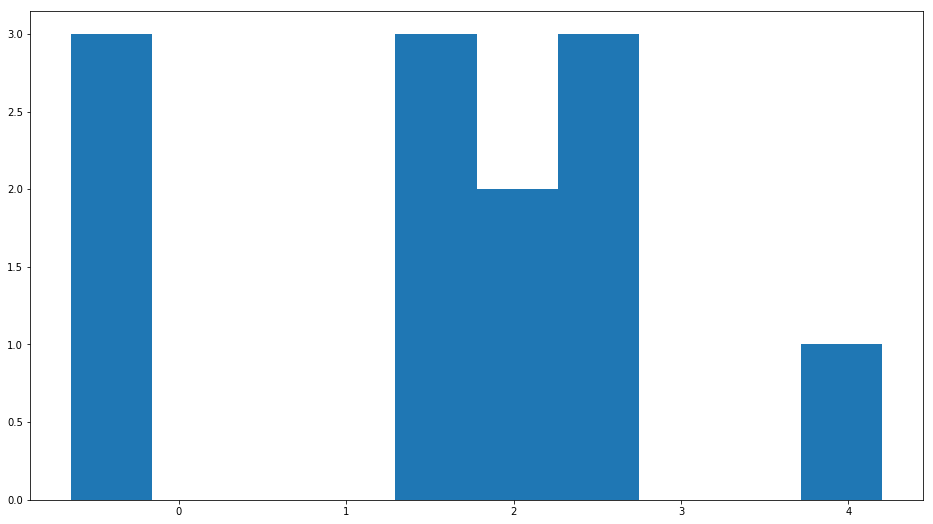

In [146]:
plt.figure(figsize=(16,9))
plt.hist(list(nx.get_node_attributes(test, "max_EI_change").values()))
plt.show()

In [71]:
coauthor_dict = {'Name':["arXiv Astrophysics Coauthorships", "High Energy Physics - Phenomenology Coauthorships",
                         "High Energy Physics - Theory Coauthorships"],
                 "Network":[], 
                 "Filename":["../data/konect_data/coauthorship/ca-AstroPh/out.ca-AstroPh", 
                             "../data/konect_data/coauthorship/ca-cit-HepPh/out.ca-cit-HepPh", 
                             "../data/konect_data/coauthorship/ca-cit-HepTh/out.ca-cit-HepTh"]}

for fn in coauthor_dict['Filename']:
    with open(fn, 'rt') as f:
        print(fn)
        try:
            g = nx.parse_edgelist(f, comments='%', create_using=nx.DiGraph())
        except:
            g = nx.parse_edgelist(f, comments='%', create_using=nx.DiGraph(), 
                              data=[('weight', float), ('paperID', float)])
        if g.number_of_nodes() < smaller_than:
            coauthor_dict['Network'].append(g)
        
print()
for net in range(len(coauthor_dict['Network'])):
    print(coauthor_dict['Name'][net], "has",
          coauthor_dict['Network'][net].number_of_nodes(), "nodes and",
          coauthor_dict['Network'][net].number_of_edges(), "edges.")

../data/konect_data/coauthorship/ca-AstroPh/out.ca-AstroPh
../data/konect_data/coauthorship/ca-cit-HepPh/out.ca-cit-HepPh
../data/konect_data/coauthorship/ca-cit-HepTh/out.ca-cit-HepTh



In [ ]:
communic_dict = {'Name':["Tarragona Emails", "DNC Emails", "EU Emails", 
                         "Facebook Wall Posts", "Linux Kernel Email List", "Digg Replies", "UC Irvine Messages",
                         "Manufacturing Company Emails", "Slashdot Threads"], 
                 "Network":[], 
                 "Filename":["../data/konect_data/communication/arenas-email/out.arenas-email", 
                             "../data/konect_data/communication/dnc-temporalGraph/out.dnc-temporalGraph", 
                             "../data/konect_data/communication/email-EuAll/out.email-EuAll", 
                             "../data/konect_data/communication/facebook-wosn-wall/out.facebook-wosn-wall",
                             "../data/konect_data/communication/lkml-reply/out.lkml-reply", 
                             "../data/konect_data/communication/munmun_digg_reply/out.munmun_digg_reply", 
                             "../data/konect_data/communication/opsahl-ucsocial/out.opsahl-ucsocial", 
                             "../data/konect_data/communication/radoslaw_email/out.radoslaw_email_email", 
                             "../data/konect_data/communication/slashdot-threads/out.slashdot-threads"]}

for fn in communic_dict['Filename']:
    with open(fn, 'rt') as f:
        print(fn)
        try:
            g = nx.parse_edgelist(f, comments='%', create_using=nx.DiGraph())
        except:
            g = nx.parse_edgelist(f, comments='%', create_using=nx.DiGraph(), 
                              data=[('weight', float), ('timestamp', float)])
        if g.number_of_nodes() < smaller_than:
            communic_dict['Network'].append(g)
        
print()
for net in range(len(communic_dict['Network'])):
    print(communic_dict['Name'][net], "has",
          communic_dict['Network'][net].number_of_nodes(), "nodes and",
          communic_dict['Network'][net].number_of_edges(), "edges.")

In [73]:
computer_dict = {'Name':["CAIDA Autonomous Systems", 
                         "as20000102 Autonomous Systems", "p2p Gnutella", "Internet Autonomous Systems"], 
                 "Network":[], 
                 "Filename":["../data/konect_data/computer/as-caida20071105/out.as-caida20071105", 
                             "../data/konect_data/computer/as20000102/out.as20000102", 
                             "../data/konect_data/computer/p2p-Gnutella31/out.p2p-Gnutella31", 
                             "../data/konect_data/computer/topology/out.topology"]}

for fn in computer_dict['Filename']:
    with open(fn, 'rt') as f:
        print(fn)
        try:
            g = nx.parse_edgelist(f, comments='%', create_using=nx.DiGraph())
        except:
            g = nx.parse_edgelist(f, comments='%', create_using=nx.DiGraph(), 
                              data=[('weight', float), ('timestamp', float)])
        if g.number_of_nodes() < smaller_than:
            computer_dict['Network'].append(g)
        
print()
for net in range(len(computer_dict['Network'])):
    print(computer_dict['Name'][net], "has",
          computer_dict['Network'][net].number_of_nodes(), "nodes and",
          computer_dict['Network'][net].number_of_edges(), "edges.")

../data/konect_data/computer/as-caida20071105/out.as-caida20071105
../data/konect_data/computer/as20000102/out.as20000102
../data/konect_data/computer/p2p-Gnutella31/out.p2p-Gnutella31
../data/konect_data/computer/topology/out.topology



In [74]:
humancon_dict = {'Name':["RFID Contact", "Reality Mining", "California Windsurfers", "Train Terrorists",
                         "RFID Hypertext Conference", "RFID Infectious Conference"], 
                 "Network":[], 
                 "Filename":["../data/konect_data/humancontact/contact/out.contact", 
                             "../data/konect_data/humancontact/mit/out.mit", 
                             "../data/konect_data/humancontact/moreno_beach/out.moreno_beach_beach", 
                             "../data/konect_data/humancontact/moreno_train/out.moreno_train_train", 
                             "../data/konect_data/humancontact/sociopatterns-hypertext/out.sociopatterns-hypertext",
                             "../data/konect_data/humancontact/sociopatterns-infectious/out.sociopatterns-infectious"]}

for fn in humancon_dict['Filename']:
    with open(fn, 'rt') as f:
        print(fn)
        try:
            g = nx.parse_edgelist(f, comments='%', create_using=nx.DiGraph())
        except:
            try:
                g = nx.parse_edgelist(f, comments='%', create_using=nx.DiGraph(),
                                      data=[('weight', float)])
            except:
                g = nx.parse_edgelist(f, comments='%', create_using=nx.DiGraph(), 
                                  data=[('weight', float), ('timestamp', float)])
        if g.number_of_nodes() < smaller_than:
            humancon_dict['Network'].append(g)
        
print()
for net in range(len(humancon_dict['Network'])):
    print(humancon_dict['Name'][net], "has",
          humancon_dict['Network'][net].number_of_nodes(), "nodes and",
          humancon_dict['Network'][net].number_of_edges(), "edges.")

../data/konect_data/humancontact/contact/out.contact
../data/konect_data/humancontact/mit/out.mit
../data/konect_data/humancontact/moreno_beach/out.moreno_beach_beach
../data/konect_data/humancontact/moreno_train/out.moreno_train_train
../data/konect_data/humancontact/sociopatterns-hypertext/out.sociopatterns-hypertext
../data/konect_data/humancontact/sociopatterns-infectious/out.sociopatterns-infectious

RFID Contact has 274 nodes and 2899 edges.
Reality Mining has 96 nodes and 2539 edges.
California Windsurfers has 43 nodes and 335 edges.
Train Terrorists has 64 nodes and 242 edges.
RFID Hypertext Conference has 113 nodes and 2195 edges.
RFID Infectious Conference has 410 nodes and 2764 edges.


In [75]:
humansoc_dict = {'Name':["Jazz Musicians", "Ad Health", "Physician Innovations", "University Residents", 
                         "Monk Cloister Network", "7th Grade Students", "Household Gift-giving", 
                         "Freshmen Students", "Gahuku–Gama Alliance Structure"], 
                 "Network":[], 
                 "Filename":["../data/konect_data/humansocial/arenas-jazz/out.arenas-jazz", 
                             "../data/konect_data/humansocial/moreno_health/out.moreno_health_health", 
                             "../data/konect_data/humansocial/moreno_innovation/out.moreno_innovation_innovation", 
                             "../data/konect_data/humansocial/moreno_oz/out.moreno_oz_oz", 
                             "../data/konect_data/humansocial/moreno_sampson/out.moreno_sampson_sampson", 
                             "../data/konect_data/humansocial/moreno_seventh/out.moreno_seventh_seventh", 
                             "../data/konect_data/humansocial/moreno_taro/out.moreno_taro_taro", 
                             "../data/konect_data/humansocial/moreno_vdb/out.moreno_vdb_vdb", 
                             "../data/konect_data/humansocial/ucidata-gama/out.ucidata-gama"]}

for fn in humansoc_dict['Filename']:
    with open(fn, 'rt') as f:
        print(fn)
        try:
            g = nx.parse_edgelist(f, comments='%', create_using=nx.DiGraph())
        except:
            try:
                g = nx.parse_edgelist(f, comments='%', create_using=nx.DiGraph(),
                                      data=[('weight', float)])
            except:
                g = nx.parse_edgelist(f, comments='%', create_using=nx.DiGraph(), 
                                  data=[('weight', float), ('timestamp', float)])
        if g.number_of_nodes() < smaller_than:
            humansoc_dict['Network'].append(g)
        
print()
for net in range(len(humansoc_dict['Network'])):
    print(humansoc_dict['Name'][net], "has",
          humansoc_dict['Network'][net].number_of_nodes(), "nodes and",
          humansoc_dict['Network'][net].number_of_edges(), "edges.")

../data/konect_data/humansocial/arenas-jazz/out.arenas-jazz
../data/konect_data/humansocial/moreno_health/out.moreno_health_health
../data/konect_data/humansocial/moreno_innovation/out.moreno_innovation_innovation
../data/konect_data/humansocial/moreno_oz/out.moreno_oz_oz
../data/konect_data/humansocial/moreno_sampson/out.moreno_sampson_sampson
../data/konect_data/humansocial/moreno_seventh/out.moreno_seventh_seventh
../data/konect_data/humansocial/moreno_taro/out.moreno_taro_taro
../data/konect_data/humansocial/moreno_vdb/out.moreno_vdb_vdb
../data/konect_data/humansocial/ucidata-gama/out.ucidata-gama

Jazz Musicians has 198 nodes and 2742 edges.
Ad Health has 241 nodes and 1098 edges.
Physician Innovations has 217 nodes and 2671 edges.
University Residents has 18 nodes and 188 edges.
Monk Cloister Network has 29 nodes and 375 edges.
7th Grade Students has 22 nodes and 78 edges.
Household Gift-giving has 32 nodes and 709 edges.
Freshmen Students has 16 nodes and 57 edges.


In [152]:
hyperlin_dict = {'Name':["Free On-line Dictionary of Computing", "Political Blogs"],
                 "Network":[], 
                 "Filename":["../data/konect_data/hyperlink/foldoc/out.foldoc", 
                             "../data/konect_data/hyperlink/moreno_blogs/out.moreno_blogs_blogs"]}

for fn in hyperlin_dict['Filename']:
    with open(fn, 'rt') as f:
        print(fn)
        try:
            print("1")
            g = nx.parse_edgelist(f, comments='%', create_using=nx.DiGraph())
        except:
            try:
                print("2")
                g = nx.parse_edgelist(f, comments='%', create_using=nx.DiGraph(),
                                      data=[('weight', float)])
            except:
                print("3")
                g = nx.parse_edgelist(f, comments='%', create_using=nx.DiGraph(), 
                                  data=[('weight', float), ('timestamp', float)])
#         if g.number_of_nodes() < smaller_than:
        hyperlin_dict['Network'].append(g)
        
print()
for net in range(len(hyperlin_dict['Network'])):
    print(hyperlin_dict['Name'][net], "has",
          hyperlin_dict['Network'][net].number_of_nodes(), "nodes and",
          hyperlin_dict['Network'][net].number_of_edges(), "edges.")

../data/konect_data/hyperlink/foldoc/out.foldoc
1
2
../data/konect_data/hyperlink/moreno_blogs/out.moreno_blogs_blogs
1

Free On-line Dictionary of Computing has 13356 nodes and 120237 edges.
Political Blogs has 1224 nodes and 19025 edges.


In [77]:
infrastr_dict = {'Name':["Federal Aviation Association", "Open Flights v1", "Open Flights v2", "U.S. Powergrid",
                         "U.S. Airports"],
                 "Network":[], 
                 "Filename":["../data/konect_data/infrastructure/maayan-faa/out.maayan-faa", 
                             "../data/konect_data/infrastructure/openflights/out.openflights",
                             "../data/konect_data/infrastructure/opsahl-openflights/out.opsahl-openflights",
                             "../data/konect_data/infrastructure/opsahl-powergrid/out.opsahl-powergrid",
                             "../data/konect_data/infrastructure/opsahl-usairport/out.opsahl-usairport"]}

for fn in infrastr_dict['Filename']:
    with open(fn, 'rt') as f:
        print(fn)
        try:
            g = nx.parse_edgelist(f, comments='%', create_using=nx.DiGraph())
        except:
            try:
                g = nx.parse_edgelist(f, comments='%', create_using=nx.DiGraph(),
                                      data=[('weight', float)])
            except:
                g = nx.parse_edgelist(f, comments='%', create_using=nx.DiGraph(), 
                                  data=[('weight', float), ('timestamp', float)])
        if g.number_of_nodes() < smaller_than:
            infrastr_dict['Network'].append(g)
        
print()
for net in range(len(infrastr_dict['Network'])):
    print(infrastr_dict['Name'][net], "has",
          infrastr_dict['Network'][net].number_of_nodes(), "nodes and",
          infrastr_dict['Network'][net].number_of_edges(), "edges.")

../data/konect_data/infrastructure/maayan-faa/out.maayan-faa
../data/konect_data/infrastructure/openflights/out.openflights
../data/konect_data/infrastructure/opsahl-openflights/out.opsahl-openflights
../data/konect_data/infrastructure/opsahl-powergrid/out.opsahl-powergrid
../data/konect_data/infrastructure/opsahl-usairport/out.opsahl-usairport

Federal Aviation Association has 1226 nodes and 2615 edges.
Open Flights v1 has 1574 nodes and 28235 edges.


In [78]:
lexicals_dict = {'Name':["David Copperfield Adj-Noun", "Edinburgh Associative Thesaurus",  
                         "King James Bible Nouns"],
                 "Network":[], 
                 "Filename":["../data/konect_data/lexical/adjnoun_adjacency/out.adjnoun_adjacency_adjacency", 
                             "../data/konect_data/lexical/eat/out.eat", 
                             "../data/konect_data/lexical/moreno_names/out.moreno_names_names"]} 

for fn in lexicals_dict['Filename']:
    with open(fn, 'rt') as f:
        print(fn)
        try:
            g = nx.parse_edgelist(f, comments='%', create_using=nx.DiGraph())
        except:
            try:
                g = nx.parse_edgelist(f, comments='%', create_using=nx.DiGraph(),
                                      data=[('weight', float)])
            except:
                g = nx.parse_edgelist(f, comments='%', create_using=nx.DiGraph(), 
                                  data=[('weight', float), ('timestamp', float)])
        if g.number_of_nodes() < smaller_than:
            lexicals_dict['Network'].append(g)
        
print()
for net in range(len(lexicals_dict['Network'])):
    print(lexicals_dict['Name'][net], "has",
          lexicals_dict['Network'][net].number_of_nodes(), "nodes and",
          lexicals_dict['Network'][net].number_of_edges(), "edges.")

../data/konect_data/lexical/adjnoun_adjacency/out.adjnoun_adjacency_adjacency
../data/konect_data/lexical/eat/out.eat
../data/konect_data/lexical/moreno_names/out.moreno_names_names

David Copperfield Adj-Noun has 112 nodes and 425 edges.
Edinburgh Associative Thesaurus has 1773 nodes and 9130 edges.


In [153]:
metaboli_dict = {'Name':["C. Elegans Metabolic", "PPI Humans - Figeys", "PPI - PDZbase", 
                         "PPI Humans - Stelzl", "PPI Humans - Vidal", "PPI Yeast", "Reactome"], 
                 "Network":[], 
                 "Filename":["../data/konect_data/metabolic/arenas-meta/out.arenas-meta", 
                             "../data/konect_data/metabolic/maayan-figeys/out.maayan-figeys",
                             "../data/konect_data/metabolic/maayan-pdzbase/out.maayan-pdzbase",
                             "../data/konect_data/metabolic/maayan-Stelzl/out.maayan-Stelzl",
                             "../data/konect_data/metabolic/maayan-vidal/out.maayan-vidal",
                             "../data/konect_data/metabolic/moreno_propro/out.moreno_propro_propro",
                             "../data/konect_data/metabolic/reactome/out.reactome"]}

for fn in metaboli_dict['Filename']:
    with open(fn, 'rt') as f:
        print(fn)
        try:
            g = nx.parse_edgelist(f, comments='%', create_using=nx.DiGraph())
        except:
            try:
                g = nx.parse_edgelist(f, comments='%', create_using=nx.DiGraph(),
                                      data=[('weight', float)])
            except:
                g = nx.parse_edgelist(f, comments='%', create_using=nx.DiGraph(), 
                                  data=[('weight', float), ('timestamp', float)])
#         if g.number_of_nodes() < smaller_than:
        metaboli_dict['Network'].append(g)
        
print()
for net in range(len(metaboli_dict['Network'])):
    print(metaboli_dict['Name'][net], "has",
          metaboli_dict['Network'][net].number_of_nodes(), "nodes and",
          metaboli_dict['Network'][net].number_of_edges(), "edges.")

../data/konect_data/metabolic/arenas-meta/out.arenas-meta
../data/konect_data/metabolic/maayan-figeys/out.maayan-figeys
../data/konect_data/metabolic/maayan-pdzbase/out.maayan-pdzbase
../data/konect_data/metabolic/maayan-Stelzl/out.maayan-Stelzl
../data/konect_data/metabolic/maayan-vidal/out.maayan-vidal
../data/konect_data/metabolic/moreno_propro/out.moreno_propro_propro
../data/konect_data/metabolic/reactome/out.reactome

C. Elegans Metabolic has 453 nodes and 2040 edges.
PPI Humans - Figeys has 2239 nodes and 6452 edges.
PPI - PDZbase has 212 nodes and 244 edges.
PPI Humans - Stelzl has 1706 nodes and 6207 edges.
PPI Humans - Vidal has 3133 nodes and 6726 edges.
PPI Yeast has 1870 nodes and 2277 edges.
Reactome has 6327 nodes and 147547 edges.


In [80]:
socialne_dict = {'Name':["Avogato", "Google+", "Facebook", "Brightkite"],
                 "Network":[], 
                 "Filename":["../data/konect_data/social/advogato/out.advogato", 
                             "../data/konect_data/social/ego-gplus/out.ego-gplus",
                             "../data/konect_data/social/facebook-wosn-links/out.facebook-wosn-links",
                             "../data/konect_data/social/loc-brightkite_edges/out.loc-brightkite_edges"]}

for fn in socialne_dict['Filename']:
    with open(fn, 'rt') as f:
        print(fn)
        try:
            g = nx.parse_edgelist(f, comments='%', create_using=nx.DiGraph())
        except:
            try:
                g = nx.parse_edgelist(f, comments='%', create_using=nx.DiGraph(),
                                      data=[('weight', float)])
            except:
                g = nx.parse_edgelist(f, comments='%', create_using=nx.DiGraph(), 
                                  data=[('weight', float), ('timestamp', float)])
        if g.number_of_nodes() < smaller_than:
            socialne_dict['Network'].append(g)
        
print()
for net in range(len(socialne_dict['Network'])):
    print(socialne_dict['Name'][net], "has",
          socialne_dict['Network'][net].number_of_nodes(), "nodes and",
          socialne_dict['Network'][net].number_of_edges(), "edges.")

../data/konect_data/social/advogato/out.advogato
../data/konect_data/social/ego-gplus/out.ego-gplus
../data/konect_data/social/facebook-wosn-links/out.facebook-wosn-links
../data/konect_data/social/loc-brightkite_edges/out.loc-brightkite_edges



In [81]:
software_dict = {'Name':["Linux Dependencies", "JDK 1.6.0.7 Dependency Framework", "JUNG 2.0.1 & Javax 1.6.0.7"],
                 "Network":[], 
                 "Filename":["../data/konect_data/software/linux/out.linux", 
                             "../data/konect_data/software/subelj_jdk/out.subelj_jdk_jdk", 
                             "../data/konect_data/software/subelj_jung-j/out.subelj_jung-j_jung-j"]}

for fn in software_dict['Filename']:
    with open(fn, 'rt') as f:
        print(fn)
        try:
            g = nx.parse_edgelist(f, comments='%', create_using=nx.DiGraph())
        except:
            try:
                g = nx.parse_edgelist(f, comments='%', create_using=nx.DiGraph(),
                                      data=[('weight', float)])
            except:
                g = nx.parse_edgelist(f, comments='%', create_using=nx.DiGraph(), 
                                  data=[('weight', float), ('timestamp', float)])
        if g.number_of_nodes() < smaller_than:
            software_dict['Network'].append(g)
        
print()
for net in range(len(software_dict['Network'])):
    print(software_dict['Name'][net], "has",
          software_dict['Network'][net].number_of_nodes(), "nodes and",
          software_dict['Network'][net].number_of_edges(), "edges.")

../data/konect_data/software/linux/out.linux
../data/konect_data/software/subelj_jdk/out.subelj_jdk_jdk
../data/konect_data/software/subelj_jung-j/out.subelj_jung-j_jung-j



In [82]:
trophicl_dict = {'Name':["South Florida Foodweb - Dry", "South Florida Foodweb - Wet", "Little Rock Lake Foodweb"],
                 "Network":[], 
                 "Filename":["../data/konect_data/trophic/foodweb-baydry/out.foodweb-baydry", 
                             "../data/konect_data/trophic/foodweb-baywet/out.foodweb-baywet", 
                             "../data/konect_data/trophic/maayan-foodweb/out.maayan-foodweb"]}

for fn in trophicl_dict['Filename']:
    with open(fn, 'rt') as f:
        print(fn)
        try:
            g = nx.parse_edgelist(f, comments='%', create_using=nx.DiGraph())
        except:
            try:
                g = nx.parse_edgelist(f, comments='%', create_using=nx.DiGraph(),
                                      data=[('weight', float)])
            except:
                g = nx.parse_edgelist(f, comments='%', create_using=nx.DiGraph(), 
                                  data=[('weight', float), ('timestamp', float)])
        if g.number_of_nodes() < smaller_than:
            trophicl_dict['Network'].append(g)
        
print()
for net in range(len(trophicl_dict['Network'])):
    print(trophicl_dict['Name'][net], "has",
          trophicl_dict['Network'][net].number_of_nodes(), "nodes and",
          trophicl_dict['Network'][net].number_of_edges(), "edges.")

../data/konect_data/trophic/foodweb-baydry/out.foodweb-baydry
../data/konect_data/trophic/foodweb-baywet/out.foodweb-baywet
../data/konect_data/trophic/maayan-foodweb/out.maayan-foodweb

South Florida Foodweb - Dry has 128 nodes and 2136 edges.
South Florida Foodweb - Wet has 128 nodes and 2105 edges.
Little Rock Lake Foodweb has 183 nodes and 2494 edges.


In [84]:
konect_dict = {"citations":      citation_dict, 
               "coauthorship":   coauthor_dict, 
               "communication":  communic_dict, 
               "computer":       computer_dict, 
               "humancontact":   humancon_dict, 
               "humansocial":    humansoc_dict, 
               "hyperlink":      hyperlin_dict, 
               "infrastructure": infrastr_dict, 
               "lexical":        lexicals_dict, 
               "metabolic":      metaboli_dict, 
               "social":         socialne_dict, 
               "software":       software_dict, 
               "trophic":        trophicl_dict}

In [83]:
# konect2000 = pd.read_csv("../data/konect_data/konect_csv_N2000.csv")
# sorted(list(konect2000['names']))

In [86]:
konect_names = []
for i in range(len(list(konect_dict.values()))):
    for name in list(konect_dict.values())[i]['Name']:
        konect_names.append(name)
sorted(konect_names)

['7th Grade Students',
 'Ad Health',
 'Avogato',
 'Brightkite',
 'C. Elegans Metabolic',
 'CAIDA Autonomous Systems',
 'California Windsurfers',
 'Cora Citations',
 'DBLP Citations',
 'DNC Emails',
 'David Copperfield Adj-Noun',
 'Digg Replies',
 'EU Emails',
 'Edinburgh Associative Thesaurus',
 'Facebook',
 'Facebook Wall Posts',
 'Federal Aviation Association',
 'Free On-line Dictionary of Computing',
 'Freshmen Students',
 'Gahuku–Gama Alliance Structure',
 'Google+',
 'High Energy Physics - Phenomenology',
 'High Energy Physics - Phenomenology Coauthorships',
 'High Energy Physics - Theory',
 'High Energy Physics - Theory Coauthorships',
 'Household Gift-giving',
 'Internet Autonomous Systems',
 'JDK 1.6.0.7 Dependency Framework',
 'JUNG 2.0.1 & Javax 1.6.0.7',
 'Jazz Musicians',
 'King James Bible Nouns',
 'Linux Dependencies',
 'Linux Kernel Email List',
 'Little Rock Lake Foodweb',
 'Manufacturing Company Emails',
 'Monk Cloister Network',
 'Open Flights v1',
 'Open Flights v2',

In [87]:
# missing = 
list(set(list(konect2000['names'])) - set(konect_names))

['Rhesus Brain 1',
 'ERIS Power Network',
 'Wikipedia Norms',
 'Rat Brain 1',
 'Drosophila Medulla',
 'Rhesus Cerebral Cortex',
 'C. elegans Connectome',
 'Mouse Brain',
 'Kasthuri Mouse Brains',
 'Cat Brain',
 'Mouse Retina',
 'Mangwet Food Web',
 'Rat Brain 2',
 'Rattus Norvegicus Brain',
 'Rhesus Brain 2',
 'Rat Brain 3',
 'Mouse Visual Cortex 2',
 'BSC Power 09',
 'Rhesus Interareal Cortical Network',
 'St. Marks Food Web',
 'Mouse Visual Cortex 1',
 'Everglade Food Web']

# Miscellaneous Networks to Add

In [88]:
misc_names = list(set(list(konect2000['names'])) - set(konect_names))
misc_files = ["../data/misc_data/eco-everglades.edges",
              "../data/misc_data/eco-mangwet.edges",
              "../data/misc_data/power-eris1176.mtx", 
              "../data/icon_data/rhesus_brain_1.graphml",
              "../data/icon_data/rhesus_brain_2.graphml",
              "../data/misc_data/power-bcspwr09.mtx",
              "../data/icon_data/rattus.norvegicus_brain_1.graphml",
              "../data/icon_data/drosophila_medulla_1.graphml",
              '../data/celegans_nx.gml',
              "../data/icon_data/wikipedia_norms_edgelist.csv",
              "../data/icon_data/mouse_retina_1.graphml",
              "../data/icon_data/mouse_brain_1.graphml",
              "../data/rattus.norvegicus_brain_1.graphml",
              "../data/mouse_visual.cortex_2.graphml",
              "../data/icon_data/cat_mixedspecies_brain_1.graphml",
              "../data/icon_data/kasthuri_graph_v4.graphml",
              "../data/rattus.norvegicus_brain_2.graphml",
              "../data/rattus.norvegicus_brain_3.graphml",
              "../data/icon_data/rhesus_interareal.cortical.network_2.graphml",
              "../data/misc_data/eco-stmarks.edges",
              "../data/mouse_visual.cortex_1.graphml",
              "../data/icon_data/rhesus_cerebral.cortex_1.graphml"]

misc_dict = {'Name':     misc_names,
             'Network':  [],
             'Filename': misc_files}

In [89]:
for fn in misc_dict['Filename']:
    print(fn)
    try:
        G = nx.Graph(nx.read_graphml(fn))
    except:
        try:
            with open(fn, 'rt') as f:
                G = nx.parse_edgelist(f, comments='%', create_using=nx.DiGraph())
        except:
            x = np.genfromtxt(fn, delimiter=' ', dtype=None, names=True, skip_header=13, usecols=(0,1))
            xx = pd.DataFrame(x)
            xx.columns = ['source','target']
            G = nx.from_pandas_edgelist(xx,create_using=nx.DiGraph())
            
    misc_dict['Network'].append(nx.DiGraph(G))

../data/misc_data/eco-everglades.edges
../data/misc_data/eco-mangwet.edges
../data/misc_data/power-eris1176.mtx
../data/icon_data/rhesus_brain_1.graphml
../data/icon_data/rhesus_brain_2.graphml
../data/misc_data/power-bcspwr09.mtx
../data/icon_data/rattus.norvegicus_brain_1.graphml
../data/icon_data/drosophila_medulla_1.graphml
../data/celegans_nx.gml
../data/icon_data/wikipedia_norms_edgelist.csv
../data/icon_data/mouse_retina_1.graphml
../data/icon_data/mouse_brain_1.graphml
../data/rattus.norvegicus_brain_1.graphml
../data/mouse_visual.cortex_2.graphml
../data/icon_data/cat_mixedspecies_brain_1.graphml
../data/icon_data/kasthuri_graph_v4.graphml
../data/rattus.norvegicus_brain_2.graphml
../data/rattus.norvegicus_brain_3.graphml
../data/icon_data/rhesus_interareal.cortical.network_2.graphml
../data/misc_data/eco-stmarks.edges
../data/mouse_visual.cortex_1.graphml
../data/icon_data/rhesus_cerebral.cortex_1.graphml


In [101]:
misc = {"Network":[], "Name":[], "Filename":[]}
for i in range(len(misc_dict['Network'])):
    gg = misc_dict['Network'][i]
    if gg.number_of_nodes() < smaller_than:
        misc['Network'].append(gg)
        misc['Name'].append(misc_dict['Name'][i])
        misc['Filename'].append(misc_dict['Filename'][i])

In [102]:
misc

{'Network': [<networkx.classes.digraph.DiGraph at 0x126775f98>,
 'Name': ['Rhesus Brain 1',
  'ERIS Power Network',
  'Wikipedia Norms',
  'Rat Brain 1',
  'Drosophila Medulla',
  'Rhesus Cerebral Cortex',
  'C. elegans Connectome',
  'Mouse Brain',
  'Kasthuri Mouse Brains',
  'Cat Brain',
  'Mouse Retina',
  'Mangwet Food Web',
  'Rat Brain 2',
  'Rattus Norvegicus Brain',
  'Rhesus Brain 2',
  'Rat Brain 3',
  'Mouse Visual Cortex 2',
  'BSC Power 09',
  'Rhesus Interareal Cortical Network',
  'St. Marks Food Web',
  'Mouse Visual Cortex 1',
  'Everglade Food Web'],
 'Filename': ['../data/misc_data/eco-everglades.edges',
  '../data/misc_data/eco-mangwet.edges',
  '../data/misc_data/power-eris1176.mtx',
  '../data/icon_data/rhesus_brain_1.graphml',
  '../data/icon_data/rhesus_brain_2.graphml',
  '../data/misc_data/power-bcspwr09.mtx',
  '../data/icon_data/rattus.norvegicus_brain_1.graphml',
  '../data/icon_data/drosophila_medulla_1.graphml',
  '../data/celegans_nx.gml',
  '../data/ic

In [ ]:
# 11-30-18: store all the EI changes, put into a df, make dist of that by category

In [38]:
humancon_dict

{'Name': ['RFID Contact',
  'Reality Mining',
  'California Windsurfers',
  'Train Terrorists',
  'RFID Hypertext Conference',
  'RFID Infectious Conference'],
 'Network': [<networkx.classes.digraph.DiGraph at 0x1a262dbdd8>,
 'Filename': ['../data/konect_data/humancontact/contact/out.contact',
  '../data/konect_data/humancontact/mit/out.mit',
  '../data/konect_data/humancontact/moreno_beach/out.moreno_beach_beach',
  '../data/konect_data/humancontact/moreno_train/out.moreno_train_train',
  '../data/konect_data/humancontact/sociopatterns-hypertext/out.sociopatterns-hypertext',
  '../data/konect_data/humancontact/sociopatterns-infectious/out.sociopatterns-infectious']}

In [57]:
cols = ["#ba4b57","#cc5134","#daaa32","#b8ab51","#698b4a","#69d07d","#50c9b5",
        "#64b6ff","#786bdb","#573689","#c65abb","#b55083","#bfbfbf","#666666"]


In [3]:
konect_data = np.load('../data/konect_data/konect_data_best.npy').item()
labs = ["citations", "coauthorship", "communication", "computer", "connectomic", "humancontact", "humansocial", 
        "hyperlink", "infrastructure", "lexical", "metabolic", "social", "software", "trophic"]

cols = ["#ba4b57","#cc5134","#daaa32","#b8ab51","#698b4a","#69d07d","#50c9b5",
        "#64b6ff","#786bdb","#573689","#c65abb","#b55083","#bfbfbf","#666666"]
# np.random.shuffle(cols)
col_mapping = dict(zip(labs, cols))

konect_data['color'] = [col_mapping[i] for i in konect_data['types']]
konect_data['num'] = np.array(list(range(len(konect_data['effec']))))
konect_data['names'][5] = 'High Energy Physics - Ph. Coauthors'
konect_data['names'][6] = 'High Energy Physics - Th. Coauthors'

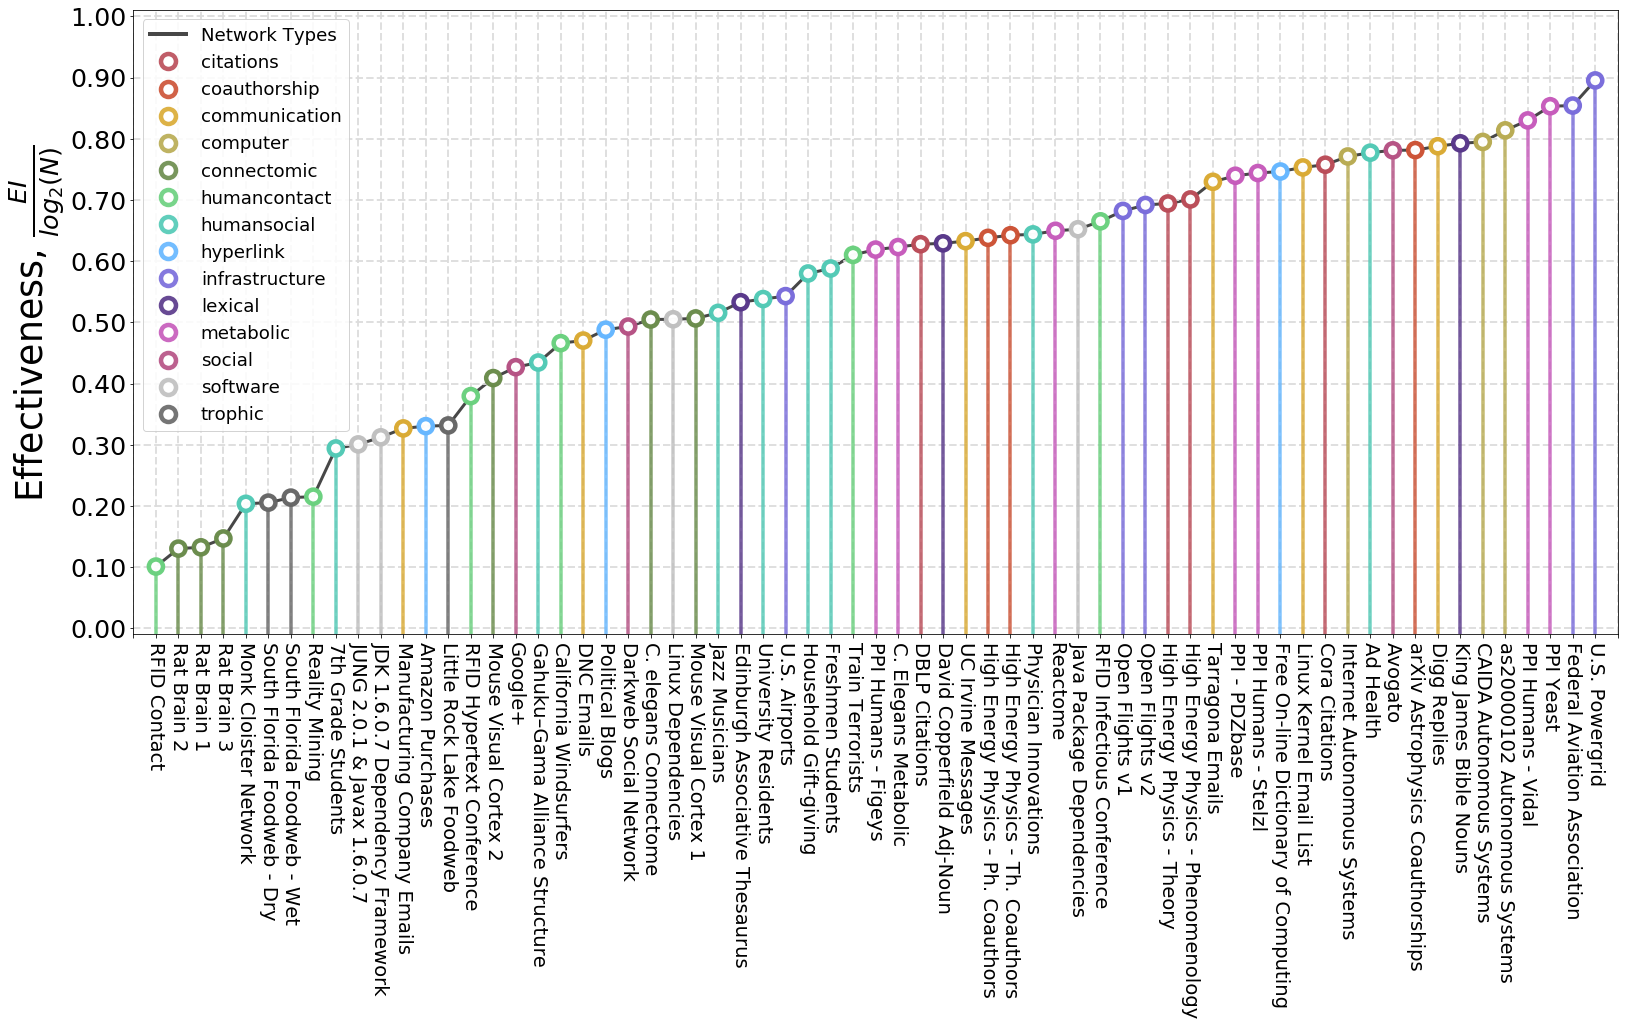

In [6]:
plt.rc('axes', axisbelow=True)

id_order = np.argsort(konect_data['effec'])
colors = np.array(konect_data['color'])#[id_order]
konect_data['color'] = np.array([col_mapping[i] for i in konect_data['types']])[id_order]
colors = np.array(konect_data['color'])#[id_order]
mult = 1.4

plt.figure(figsize=(19*mult,8.2*mult))

plt.plot([-10],[-10], marker='', 
         markersize=18, alpha=0.9, linestyle='-', linewidth=4.0,
         markeredgecolor='#333333', color='#333333', markeredgewidth=5.5, 
         markerfacecolor="w", label='Network Types')

plt.vlines(sorted(id_order),-1,np.array(konect_data['effec'])[id_order], colors=colors, 
           linewidth=3.5, alpha=0.8, zorder=1)

plt.plot(sorted(id_order), np.array(konect_data['effec'])[id_order], alpha=0.9,
         marker='', linestyle='-', linewidth=3.0, color='#333333', zorder=0)

plt.scatter(sorted(id_order), np.array(konect_data['effec'])[id_order], 
            marker='o', s=200, alpha=0.98,
            edgecolors=colors, linewidths=4.5, facecolor="w")

for types, color in col_mapping.items():
    plt.plot([-10],[-10], marker='o', 
         markersize=15, alpha=0.9, linestyle='', linewidth=3.0,
         markeredgecolor=color, markeredgewidth=4.5, 
         markerfacecolor="w", label=types)

xtix = np.linspace(-1,len(konect_data['names']),len(konect_data['names'])+2)
xticklist = [""]
for i in range(len(konect_data['names'])):
    xticklist.append(np.array(konect_data['names'])[id_order][i])
xticklist.append("")

plt.xticks(xtix, xticklist, rotation=270, size=14*mult)
plt.yticks(np.linspace(0,1,11), ["%.2f"%i for i in np.linspace(0,1,11)], size=18*mult)
plt.grid(alpha=0.9, color='gainsboro', linestyle='--', linewidth=2.0)
plt.xlim(-1,len(konect_data['names']))
plt.ylim(-0.01,1.01)
plt.ylabel(r'Effectiveness, $\frac{EI}{log_2(N)}$', size=26*mult)
plt.legend(loc=2, fontsize=13*mult, framealpha=0.85)

# plt.savefig("../figs/pngs/Konect_SortedEffectiveness.png", dpi=425, bbox_inches='tight')
# plt.savefig("../figs/pdfs/Konect_SortedEffectiveness.pdf", bbox_inches='tight')
plt.show()

In [7]:
newty = ["information","information","social","technological","biological","social","social","information",
         "technological","information","biological","social","information","biological"]
newty = dict(zip(list(np.unique(konect_data['types'])), newty))

konect_data['newty'] = [newty[i] for i in konect_data['types']]

newco = ["#c34b57","#c6b950","#865db4","#64b9b0"]
newco = dict(zip(list(np.unique(konect_data['newty'])), newco))

konect_data['newco'] = [newco[i] for i in konect_data['newty']]

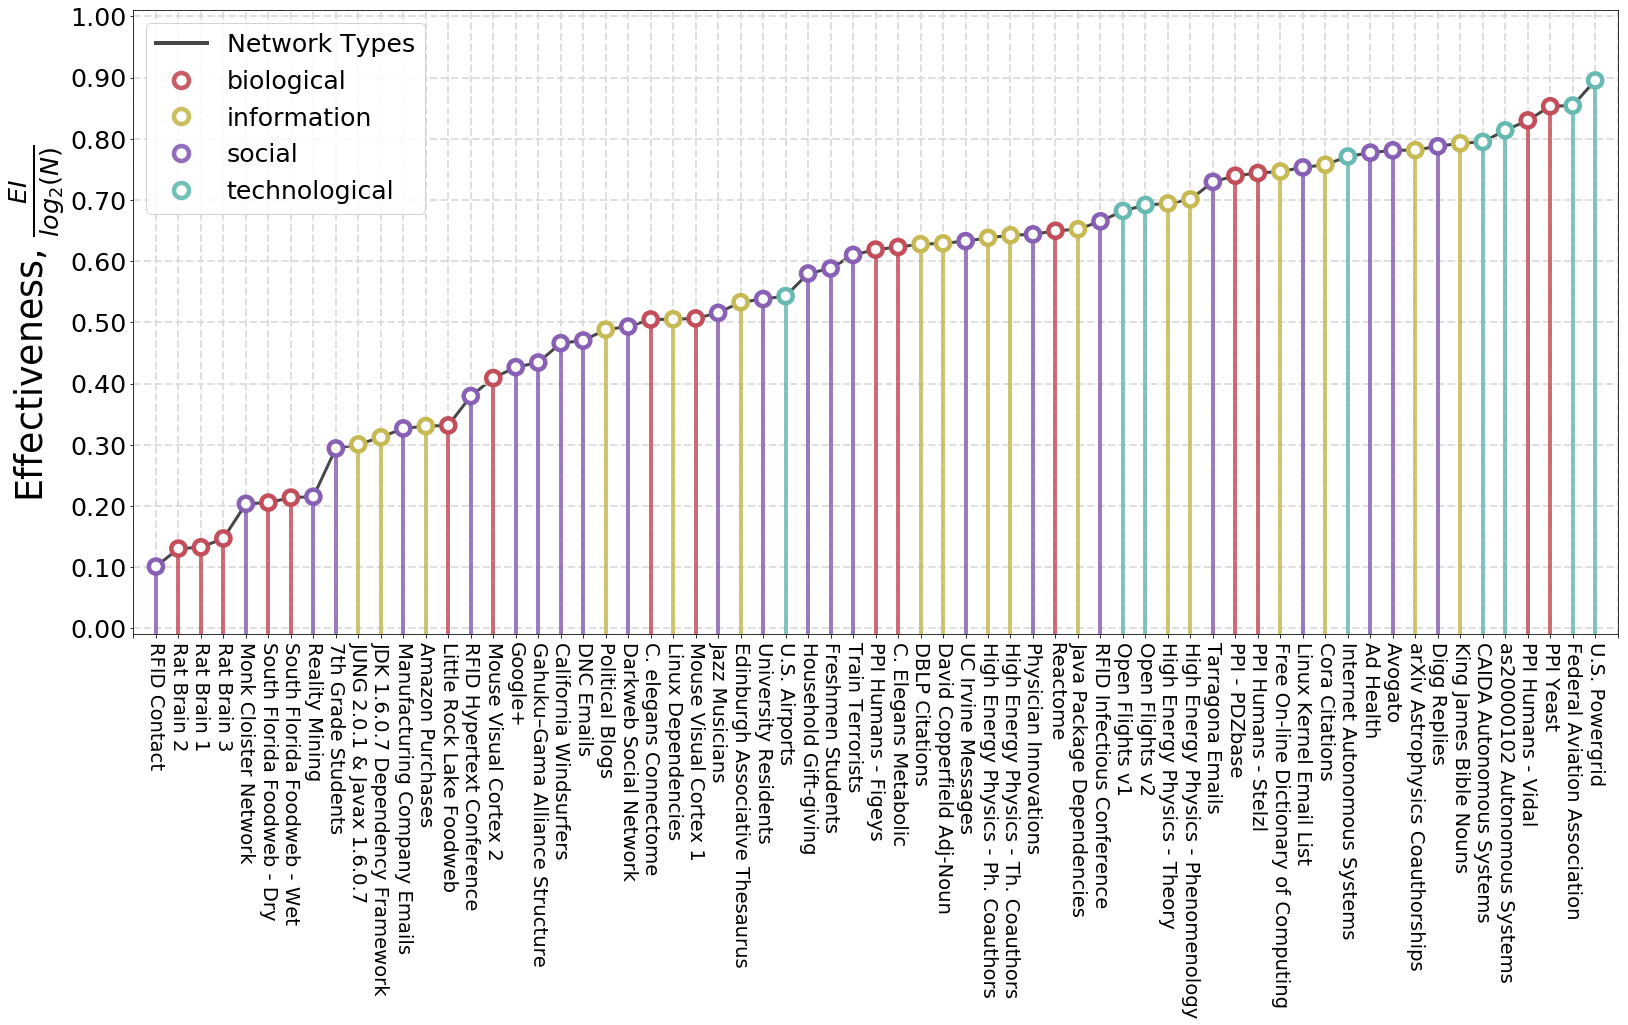

In [72]:
plt.rc('axes', axisbelow=True)

id_order = np.argsort(konect_data['effec'])
colors = np.array(konect_data['newco'])[id_order]
mult = 1.4

plt.figure(figsize=(19*mult,8.2*mult))

plt.plot([-10],[-10], marker='', 
         markersize=18, alpha=0.9, linestyle='-', linewidth=4.0,
         markeredgecolor='#333333', color='#333333', markeredgewidth=5.5, 
         markerfacecolor="w", label='Network Types')

plt.vlines(sorted(id_order),-1,np.array(konect_data['effec'])[id_order], colors=colors, 
           linewidth=4.0, alpha=0.8, zorder=1)

plt.plot(sorted(id_order), np.array(konect_data['effec'])[id_order], alpha=0.9,
         marker='', linestyle='-', linewidth=3.0, color='#333333', zorder=0)

plt.scatter(sorted(id_order), np.array(konect_data['effec'])[id_order], 
            marker='o', s=200, alpha=0.98,
            edgecolors=colors, linewidths=4.5, facecolor="w")

for types, color in newco.items():
    plt.plot([-10],[-10], marker='o', 
         markersize=15, alpha=0.9, linestyle='', linewidth=3.0,
         markeredgecolor=color, markeredgewidth=4.5, 
         markerfacecolor="w", label=types)

xtix = np.linspace(-1,len(konect_data['names']),len(konect_data['names'])+2)
xticklist = [""]
for i in range(len(konect_data['names'])):
    xticklist.append(np.array(konect_data['names'])[id_order][i])
xticklist.append("")

plt.xticks(xtix, xticklist, rotation=270, size=14*mult)
plt.yticks(np.linspace(0,1,11), ["%.2f"%i for i in np.linspace(0,1,11)], size=18*mult)
plt.grid(alpha=0.9, color='gainsboro', linestyle='--', linewidth=2.0)
plt.xlim(-1,len(konect_data['names']))
plt.ylim(-0.01,1.01)
plt.ylabel(r'Effectiveness, $\frac{EI}{log_2(N)}$', size=26*mult)
plt.legend(loc=2, fontsize=18*mult, framealpha=0.85)

# plt.savefig("../figs/pngs/Konect_SortedEffectiveness_4col.png", dpi=425, bbox_inches='tight')
# plt.savefig("../figs/pdfs/Konect_SortedEffectiveness_4col.pdf", bbox_inches='tight')
plt.show()

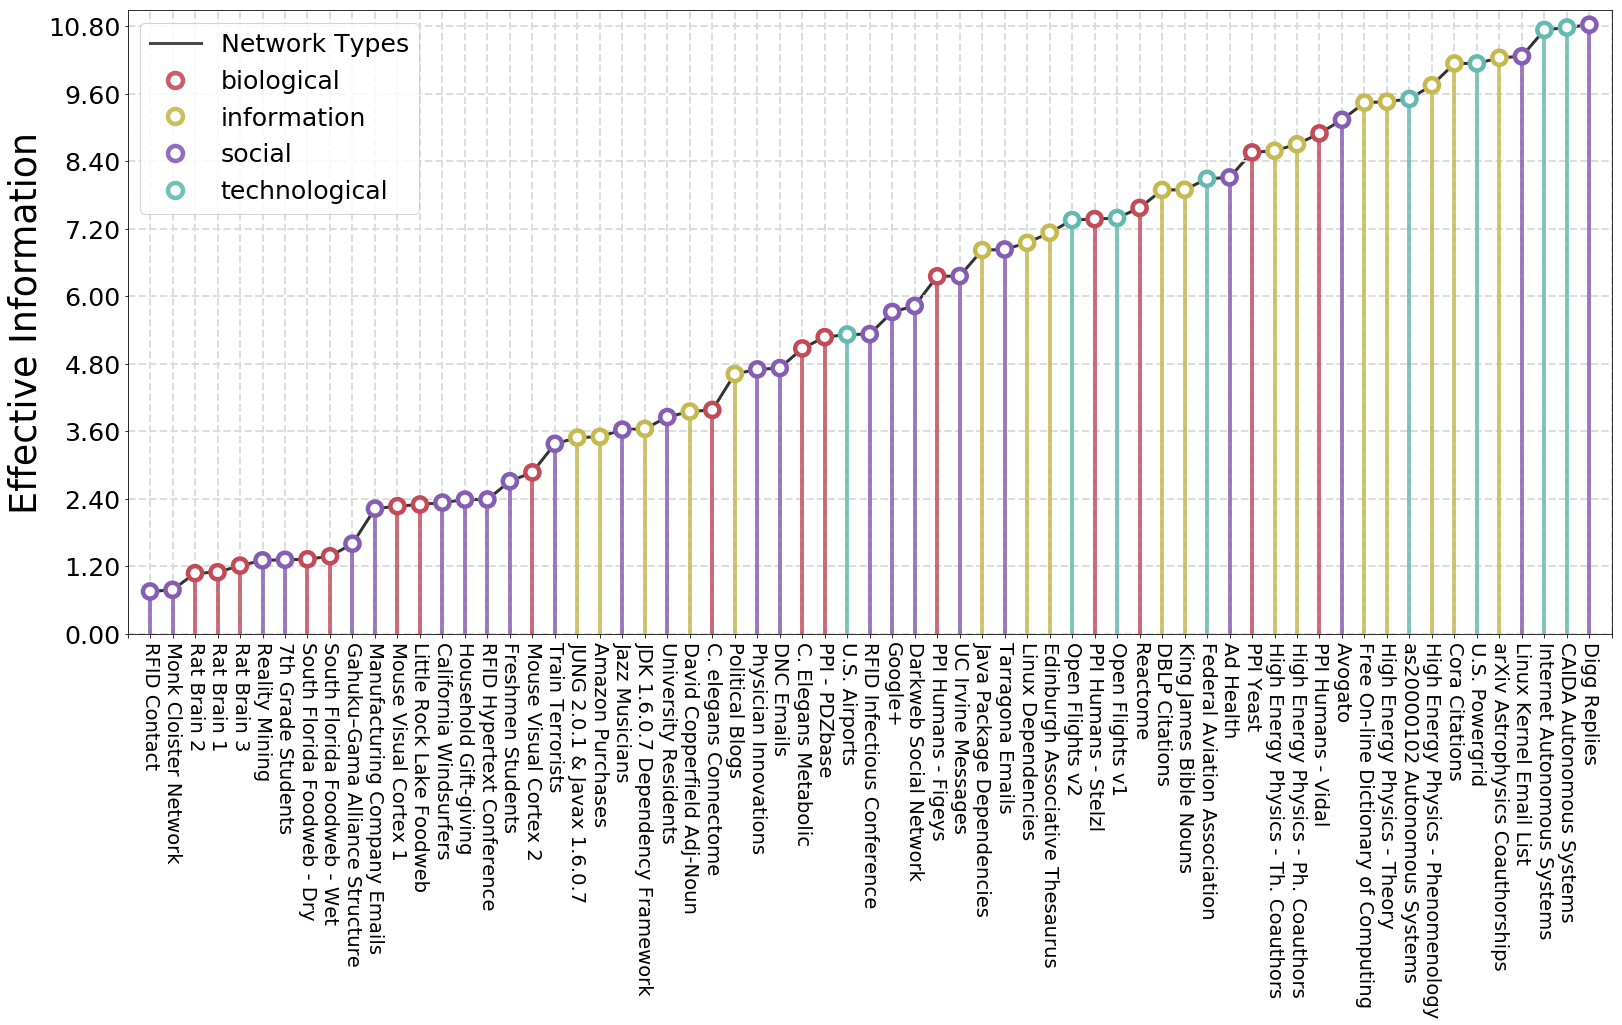

In [243]:
id_order = np.argsort(konect_data['effin'])
colors = np.array(konect_data['newco'])[id_order]
mult = 1.4

plt.figure(figsize=(19*mult,8.2*mult))

plt.plot([-10],[-10], marker='', 
         markersize=18, alpha=0.9, linestyle='-', linewidth=3.0,
         markeredgecolor='#333333', color='#333333', markeredgewidth=5.5, 
         markerfacecolor="w", label='Network Types')

plt.vlines(sorted(id_order),-1,np.array(konect_data['effin'])[id_order], colors=colors, 
           linewidth=4.0, alpha=0.8, zorder=1)

plt.plot(sorted(id_order), np.array(konect_data['effin'])[id_order], 
         marker='', linestyle='-', linewidth=3.0, color='#333333', zorder=0)

plt.scatter(sorted(id_order), np.array(konect_data['effin'])[id_order], 
            marker='o', s=200, alpha=1.0,
            edgecolors=colors, linewidths=4.5, facecolor="w")

for types, color in newco.items():
    plt.plot([-10],[-10], marker='o', 
         markersize=15, alpha=0.9, linestyle='', linewidth=3.0,
         markeredgecolor=color, markeredgewidth=4.5, 
         markerfacecolor="w", label=types)

xtix = np.linspace(-1,len(konect_data['names']),len(konect_data['names'])+2)
xticklist = [""]
for i in range(len(konect_data['names'])):
    xticklist.append(np.array(konect_data['names'])[id_order][i])
xticklist.append("")

plt.xticks(xtix, xticklist, rotation=270, size=14*mult)
plt.yticks(np.linspace(0,13,11), ["%.2f"%i for i in np.linspace(0,12,11)], size=18*mult)
plt.grid(alpha=0.95, color='gainsboro', linestyle='--', linewidth=2.0)
plt.xlim(-1,len(konect_data['names']))
plt.ylim(-0.01,12.01)
plt.ylabel('Effective Information', size=26*mult)
plt.legend(loc=2, fontsize=18*mult, framealpha=0.85)

# plt.savefig("../figs/pngs/Konect_SortedEffectiveInfo_4col.png", dpi=425, bbox_inches='tight')
# plt.savefig("../figs/pdfs/Konect_SortedEffectiveInfo_4col.pdf", bbox_inches='tight')
plt.show()

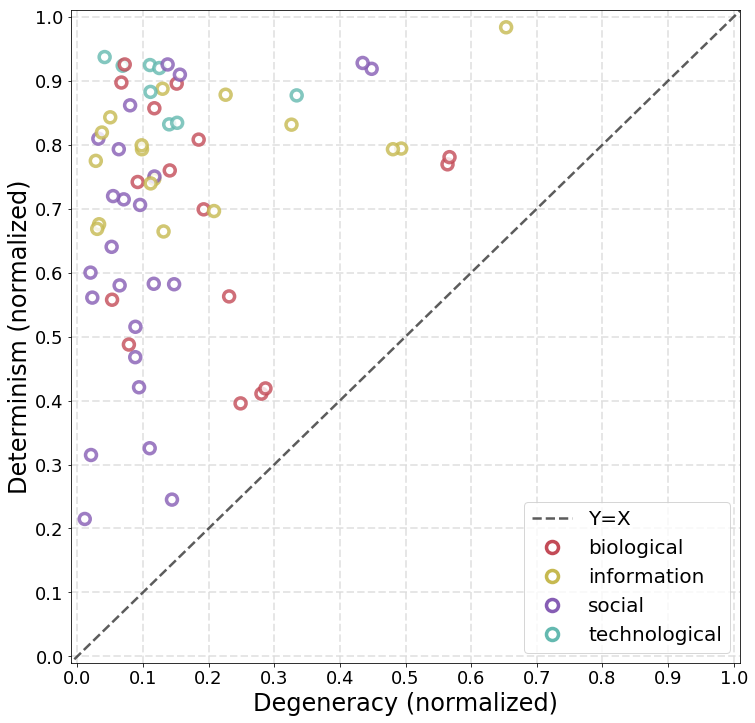

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(12,12))
plt.plot([-0.5, 20.5], [-0.5, 20.5], marker='', linestyle='--', 
            linewidth=2.5, color='#333333', label='Y=X', alpha=0.8)

ma = 'o'
si = 120
det = np.array(konect_data['deter'])
deg = np.array(konect_data['degen'])
eff = np.array(konect_data['effec'])
eis = np.array(konect_data['effin'])
id_order = np.argsort(eis)
col = np.array(konect_data['newco'])[id_order]
lab = np.array(konect_data['names'])
N   = np.array(konect_data['nodes'])

ax.scatter((deg/np.log2(N))[id_order], (det/np.log2(N))[id_order], marker=ma, s=si, 
           color='w', alpha=0.80, edgecolors=col, linewidths=3.5)
for i in newco.keys():
    ax.plot([-10],[-10],marker=ma,markersize=si/10,label=i,color='w',linestyle='',
            markeredgecolor=newco[i], markeredgewidth=3.5)

ax.set_xlabel("Degeneracy (normalized)", size=24)
ax.set_ylabel("Determinism (normalized)", size=24)
ax.set_xticks(np.round(np.linspace(0,1.0,11), 2))
ax.set_yticks(np.round(np.linspace(0,1.0,11), 2))
ax.set_xticklabels(np.round(np.linspace(0,1.0,11), 2), fontsize=18)
ax.set_yticklabels(np.round(np.linspace(0,1.0,11), 2), fontsize=18)
ax.set_xlim(-0.01, 1.01)
ax.set_ylim(-0.01, 1.01)

ax.grid(linestyle='--', color='gainsboro', linewidth=2.0, alpha=0.7)
ax.set_axisbelow(1)

ax.legend(fontsize=20, framealpha=0.8)

# plt.savefig("../figs/pngs/Konect_NormDeterm_NormDegen_4col.png", dpi=425, bbox_inches='tight')
# plt.savefig("../figs/pdfs/Konect_NormDeterm_NormDegen_4col.pdf", bbox_inches='tight')
plt.show()

________________________

In [4]:
# def get_macro(G, macro_mapping, p0=0):
#     """
#     Given an input graph and a micro-to-macro mapping, output a macro transition matrix.
#     - param G: current micro graph
#     - param macro_mapping: a dictionary with {micro_node:macro_node}
#     - param p0: smallest probability
    
#     - output: Macro, a macro-level transition-probability matrix
#     """
#     # might have to assert node_labels to be integers
#     G = prepare_network(G,p0=p0)
#     micro_network_size = G.number_of_nodes()
#     micro_Wout = get_Wout_full(G, p0)
#     micro_nodes = np.unique(list(macro_mapping.keys()))
#     nodes_in_macro_network = np.unique(list(macro_mapping.values()))

#     macro_network_size = len(nodes_in_macro_network)
#     macro_nodes = nodes_in_macro_network[nodes_in_macro_network > micro_network_size-1]
#     n_macro = len(macro_nodes)
    
#     if n_macro==0:
#         return micro_Wout
    
#     micro_to_macro_list = []
#     for macro_i in range(n_macro):
#         micro_in_macro_i = [k for k,v in macro_mapping.items() if v==macro_nodes[macro_i]]
#         micro_to_macro_list.append(micro_in_macro_i)
    
#     # get new rows
#     macro_row_list = []
#     for macro_i in micro_to_macro_list:
#         macro_row_list.append(sum(micro_Wout[macro_i,:]))
    
#     macro_rows = np.vstack(macro_row_list)

#     # get new cols
#     macro_col_list = []
#     for macro_i in micro_to_macro_list:
#         macro_col_list.append(sum(micro_Wout.T[macro_i,:]))

#     macro_cols = np.vstack(macro_col_list)    
#     macro_cols = macro_cols.T
    
#     # get stubby diagonal square in the bottom right
#     macro_bottom_right = np.zeros((n_macro,n_macro))
#     for macro_i in range(n_macro):
#         for macro_j in range(n_macro):
#             macro_bottom_right[macro_i, macro_j] = sum(macro_row_list[macro_i][micro_to_macro_list[macro_j]])

#     # put them all together in a matrix that is too big
#     too_big_macro = np.block([[micro_Wout, macro_cols], [macro_rows, macro_bottom_right]])
    
#     macro_out = too_big_macro[nodes_in_macro_network,:][:,nodes_in_macro_network]
    
#     Macro = macro_out / macro_out.sum(axis=1)[:, np.newaxis]
    
    
#     return Macro

# # PRINT VERSION, WORKS
# def causal_emergence(G, p0=0, thresh=0.0001):
#     """
#     Given a micro-scale network, iterate through possible macro-groupings and look for causal emergence.
#     - param G: a networkx object or adjacency matrix or TPM
#     - param p0: smallest probability
    
#     - output Gm: a macro-scale network object with higher EI than G
#     """
#     G = prepare_network(G, p0) # makes the network weighted, directed if it's not already
#     current_ei = get_ei(G, p0)
#     micro_nodes_left = list(G.nodes())
#     micros_that_have_been_macroed = []
#     macro_mapping = dict(zip(micro_nodes_left, micro_nodes_left))    
#     print("Starting with this tpm:\n",np.round(get_Wout_full(G,p0), 4))
#     print("\nSearch started... current_ei = %.4f"%current_ei)
#     count = 0
#     np.random.shuffle(micro_nodes_left)
#     for node_i in micro_nodes_left:
#         count += 1
#         print("%03i"%count, "...",node_i,"...","macro size =",len(np.unique(list(macro_mapping.values()))))

#         neighbors_i = set(list(G.successors(node_i))).union(set(list(G.predecessors(node_i))))
#         for node_j in neighbors_i:
#             neighbors_j = set(list(G.successors(node_j))).union(set(list(G.predecessors(node_j))))
#             neighbors_i = neighbors_j.union(neighbors_i)
#         macros_to_check = [i for i in list(neighbors_i) if i!=node_i]
#         queue = macros_to_check.copy()

#         node_i_macro = macro_mapping[node_i]
#         if node_i_macro == node_i:
#             node_i_macro = max(list(macro_mapping.values()))+1
            
#         while len(queue) > 0:
#             np.random.shuffle(queue)
#             possible_macro = queue.pop()

#             possible_mapping = macro_mapping.copy()
#             possible_mapping[node_i]         = node_i_macro
#             possible_mapping[possible_macro] = node_i_macro

#             try:
#                 MACRO = get_macro(G, possible_mapping, p0)
#                 macro_ei = get_ei(MACRO, p0)
#                 Gm = prepare_network(MACRO, p0=p0)
#             except:
#                 continue

#             MACRO = get_macro(G, possible_mapping, p0)
#             macro_ei = get_ei(MACRO, p0)
#             Gm = prepare_network(MACRO, p0=p0)

#             if macro_ei - current_ei > thresh:
#                 current_ei = macro_ei
#                 macro_mapping = possible_mapping
#                 print("just found successful macro grouping... current_ei = %.4f"%current_ei)
#                 micros_that_have_been_macroed.append(node_i)
#                 micros_that_have_been_macroed.append(possible_macro)
#                 micros_that_have_been_macroed = list(set(micros_that_have_been_macroed))

#                 nodes_in_macro_i = [k for k, v in macro_mapping.items() if v==node_i_macro]
                
#                 for new_micro_in_macro_i in nodes_in_macro_i:
#                     neighbors_Mi = set(list(
#                         G.successors(new_micro_in_macro_i))).\
#                         union(set(list(G.predecessors(new_micro_in_macro_i))))
                        
#                     for node_Mj in neighbors_Mi:
#                         if node_Mj not in queue and node_Mj != node_i:
#                             queue.append(node_Mj)
    
#     try:
#         MACRO = get_macro(G, macro_mapping, p0)
#         Gm = prepare_network(MACRO, p0=p0)
#         return Gm, macro_mapping, G
#     except:
#         return [], macro_mapping, G
    
    
def get_macro(G, macro_mapping, p0=0):
    """
    Given an input graph and a micro-to-macro mapping, output a macro transition matrix.
    - param G: current micro graph
    - param macro_mapping: a dictionary with {micro_node:macro_node}
    - param p0: smallest probability
    
    - output: Macro, a macro-level transition-probability matrix
    """
    # might have to assert node_labels to be integers
    G = prepare_network(G,p0=p0)
    micro_network_size = G.number_of_nodes()
    micro_Wout = get_Wout_full(G, p0)
    micro_nodes = np.unique(list(macro_mapping.keys()))
    nodes_in_macro_network = np.unique(list(macro_mapping.values()))

    macro_network_size = len(nodes_in_macro_network)
    macro_nodes = nodes_in_macro_network[nodes_in_macro_network > micro_network_size-1]
    n_macro = len(macro_nodes)
    
    if n_macro==0:
        return micro_Wout
    
    micro_to_macro_list = []
    for macro_i in range(n_macro):
        micro_in_macro_i = [k for k,v in macro_mapping.items() if v==macro_nodes[macro_i]]
        micro_to_macro_list.append(micro_in_macro_i)
    
    # get new rows
    macro_row_list = []
    for macro_i in micro_to_macro_list:
        macro_row_list.append(sum(micro_Wout[macro_i,:]))
    
    macro_rows = np.vstack(macro_row_list)

    # get new cols
    macro_col_list = []
    for macro_i in micro_to_macro_list:
        macro_col_list.append(sum(micro_Wout.T[macro_i,:]))

    macro_cols = np.vstack(macro_col_list)    
    macro_cols = macro_cols.T
    
    # get stubby diagonal square in the bottom right
    macro_bottom_right = np.zeros((n_macro,n_macro))
    for macro_i in range(n_macro):
        for macro_j in range(n_macro):
            macro_bottom_right[macro_i, macro_j] = sum(macro_row_list[macro_i][micro_to_macro_list[macro_j]])

    # put them all together in a matrix that is too big
    too_big_macro = np.block([[micro_Wout, macro_cols], [macro_rows, macro_bottom_right]])
    
    macro_out = too_big_macro[nodes_in_macro_network,:][:,nodes_in_macro_network]
    
    Macro = macro_out / macro_out.sum(axis=1)[:, np.newaxis]
    
    return Macro

# PRINT VERSION, WORKS
def causal_emergence(G, p0=0, thresh=0.0001, printt=True, ntimes=-1):
    """
    Given a micro-scale network, iterate through possible macro-groupings and look for causal emergence.
    - param G: a networkx object or adjacency matrix or TPM
    - param p0: smallest probability
    
    - output Gm: a macro-scale network object with higher EI than G
    """
    G = prepare_network(G, p0)
    current_ei = get_ei(G, p0)
    micro_nodes_left = list(G.nodes())
    micros_that_have_been_macroed = []
    macro_mapping = dict(zip(micro_nodes_left, micro_nodes_left))    
    if printt:
        print("Starting with this tpm:\n",np.round(get_Wout_full(G,p0), 4))
        print("\nSearch started... current_ei = %.4f"%current_ei)
    EI_G = current_ei
    change_in_ei_dict_max = {}
    change_in_ei_dict_mean = {}
    
    count = 0
    np.random.shuffle(micro_nodes_left)

    ##############
    if ntimes != -1 and ntimes < len(micro_nodes_left):
        micro_nodes_left = micro_nodes_left[:ntimes]
    ##############

    for node_i in micro_nodes_left:
        change_in_ei_dict = []
        
        count += 1
        if printt:
            print("%03i"%count, "...",node_i,"...","macro size =",len(np.unique(list(macro_mapping.values()))))

        neighbors_i = set(list(G.successors(node_i))).union(set(list(G.predecessors(node_i))))
        for node_j in neighbors_i:
            neighbors_j = set(list(G.successors(node_j))).union(set(list(G.predecessors(node_j))))
            neighbors_i = neighbors_j.union(neighbors_i)
        macros_to_check = [i for i in list(neighbors_i) if i!=node_i]
        queue = macros_to_check.copy()

        node_i_macro = macro_mapping[node_i]
        if node_i_macro == node_i:
            node_i_macro = max(list(macro_mapping.values()))+1
            
        while len(queue) > 0:
            np.random.shuffle(queue)
            possible_macro = queue.pop()

            possible_mapping = macro_mapping.copy()
            possible_mapping[node_i]         = node_i_macro
            possible_mapping[possible_macro] = node_i_macro

            try:
                MACRO = get_macro(G, possible_mapping, p0)
                macro_ei = get_ei(MACRO, p0)
                Gm = prepare_network(MACRO, p0=p0)
            except:
                continue

            MACRO = get_macro(G, possible_mapping, p0)
            macro_ei = get_ei(MACRO, p0)
            Gm = prepare_network(MACRO, p0=p0)
            
            change_in_ei_dict.append(macro_ei - EI_G)
    
            if macro_ei - current_ei > thresh:
                current_ei = macro_ei
                macro_mapping = possible_mapping
                if printt:
                    print("just found successful macro grouping... current_ei = %.4f"%current_ei)
                micros_that_have_been_macroed.append(node_i)
                micros_that_have_been_macroed.append(possible_macro)
                micros_that_have_been_macroed = list(set(micros_that_have_been_macroed))

                nodes_in_macro_i = [k for k, v in macro_mapping.items() if v==node_i_macro]
                
                for new_micro_in_macro_i in nodes_in_macro_i:
                    neighbors_Mi = set(list(
                        G.successors(new_micro_in_macro_i))).\
                        union(set(list(G.predecessors(new_micro_in_macro_i))))
                        
                    for node_Mj in neighbors_Mi:
                        if node_Mj not in queue and node_Mj != node_i:
                            queue.append(node_Mj)

        if change_in_ei_dict:
            change_in_ei_dict_mean[node_i] = np.mean(change_in_ei_dict)
            change_in_ei_dict_max[ node_i] =     max(change_in_ei_dict)
    
    nx.set_node_attributes(G, change_in_ei_dict_mean, 'mean_EI_change')
    nx.set_node_attributes(G, change_in_ei_dict_max,  'max_EI_change')
    try:
        MACRO = get_macro(G, macro_mapping, p0)
        Gm = prepare_network(MACRO, p0=p0)
        return Gm, macro_mapping, G
    except:
        return [], macro_mapping, G    

In [7]:
p0 = 0
thresh = 0.0001
N = 200
ntimes = 3

Gbara1 = nx.barabasi_albert_graph(N,1)
_, _, Gbara1 = causal_emergence(Gbara1, p0, thresh, False, ntimes)

Gerdo1 = nx.erdos_renyi_graph(N,0.01)
_, _, Gerdo1 = causal_emergence(Gerdo1, p0, thresh, False)

Gbara2 = nx.barabasi_albert_graph(N,2)
_, _, Gbara2 = causal_emergence(Gbara2, p0, thresh, False, ntimes)

Gerdo2 = nx.erdos_renyi_graph(N,0.02)
_, _, Gerdo2 = causal_emergence(Gerdo2, p0, thresh, False)

/Users/brennan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:193: RuntimeWarning: invalid value encountered in true_divide


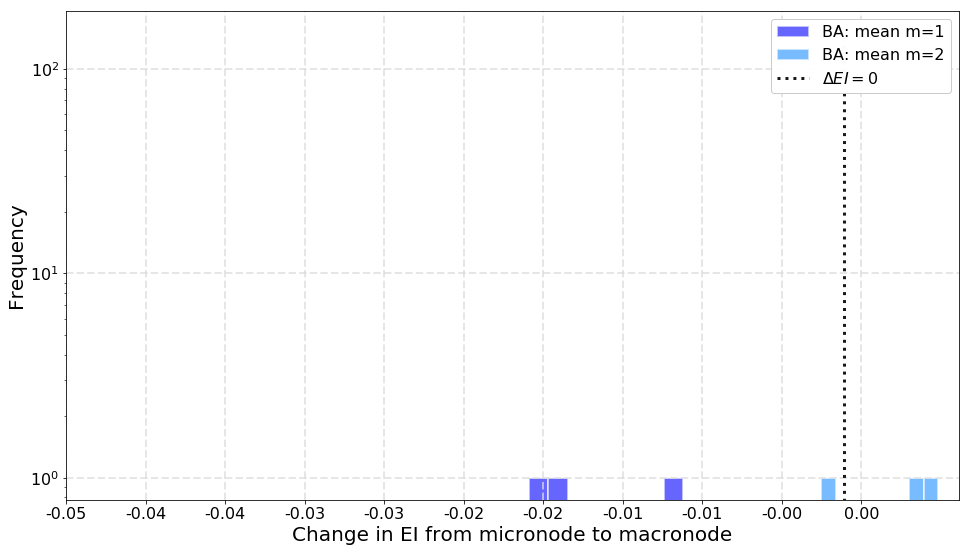

In [8]:
valsb = np.array(list(nx.get_node_attributes(Gbara1, 'max_EI_change').values()))
valse = np.array(list(nx.get_node_attributes(Gerdo1, 'max_EI_change').values()))
# valss = np.array(list(nx.get_node_attributes(Gstar1, 'max_EI_change').values()))
maxval = max([max(valsb), max(valse)])#, max(valss)])

ba1_mean = np.array(list(nx.get_node_attributes(Gbara1, 'mean_EI_change').values()))
ba2_mean = np.array(list(nx.get_node_attributes(Gbara2, 'mean_EI_change').values()))
er1_mean = np.array(list(nx.get_node_attributes(Gerdo1, 'mean_EI_change').values()))
er2_mean = np.array(list(nx.get_node_attributes(Gerdo2, 'mean_EI_change').values()))

plt.figure(figsize=(16,9))
plt.vlines(0,0,150, linestyle=':', alpha=0.9, linewidth=3.0, label=r'$\Delta EI = 0$')
plt.hist(ba1_mean + np.random.uniform(-.001, 0.001, len(ba1_mean)), #width=0.03, 
         bins=8, alpha=0.6, edgecolor='w', linewidth=2, label='BA: mean m=1',    color='blue')
plt.hist(ba2_mean + np.random.uniform(-.001, 0.001, len(ba2_mean)), #width=0.03, 
         bins=8, alpha=0.6, edgecolor='w', linewidth=2, label='BA: mean m=2',    color='dodgerblue')
# plt.hist(er1_mean + np.random.uniform(-.001, 0.001, len(er1_mean)), #width=0.03, 
#          bins=8, alpha=0.6, edgecolor='w', linewidth=2, label='ER: mean p=0.01', color='green')
# plt.hist(er2_mean + np.random.uniform(-.001, 0.001, len(er2_mean)), #width=0.03, 
#          bins=8, alpha=0.6, edgecolor='w', linewidth=2, label='ER: mean p=0.02', color='lime')

xticks = ["%.2f"%i for i in np.linspace(-0.05,maxval,11)]
yticks = ["%i"%int(i) for i in np.linspace(0,N,6)]
plt.xticks(np.linspace(-0.05,maxval,11), xticks, fontsize=16)
plt.yticks(np.linspace(0,N,6), yticks, fontsize=16)
plt.xlabel("Change in EI from micronode to macronode", fontsize=20)
plt.ylabel("Frequency", fontsize=20)
plt.grid(linestyle='--', color='gainsboro', linewidth=2.0, alpha=0.7)
plt.yscale('log')
# plt.xscale('log')
# plt.ylim(0.8,100)
plt.legend(fontsize=16, framealpha=0.99)

plt.show()

In [114]:
p0 = 0
thresh = 0.0001
ntimes = 50
printt = True
out_dict = {}

i = 1
for G_micro in humancon_dict['Network'][i:]:
    print(humancon_dict['Name'][i])
    G_micro = nx.convert_node_labels_to_integers(G_micro)
    _, _, G_micro = causal_emergence(G_micro, p0, thresh, printt, ntimes)
    
    val_ce = np.array(list(nx.get_node_attributes(G_micro, 'mean_EI_change').values()))
    out_dict[humancon_dict['Name'][i]] = val_ce
    
    i+=1

Reality Mining
Starting with this tpm:
 [[0.     0.05   0.     ... 0.     0.05   0.    ]
 [0.     0.     0.     ... 0.     0.125  0.    ]
 [0.0208 0.0208 0.     ... 0.     0.     0.    ]
 ...
 [0.0213 0.     0.0213 ... 0.     0.     0.    ]
 [0.     0.     0.     ... 0.     0.     0.    ]
 [0.0278 0.0278 0.0278 ... 0.     0.     0.    ]]

Search started... current_ei = 1.4169
001 ... 57 ... macro size = 96
just found successful macro grouping... current_ei = 1.4171


/Users/brennan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:193: RuntimeWarning: invalid value encountered in true_divide


just found successful macro grouping... current_ei = 1.4178
just found successful macro grouping... current_ei = 1.4249
just found successful macro grouping... current_ei = 1.4263
just found successful macro grouping... current_ei = 1.4298
just found successful macro grouping... current_ei = 1.4321
just found successful macro grouping... current_ei = 1.4384
just found successful macro grouping... current_ei = 1.4397
just found successful macro grouping... current_ei = 1.4450
just found successful macro grouping... current_ei = 1.4504
just found successful macro grouping... current_ei = 1.4557
just found successful macro grouping... current_ei = 1.4612
just found successful macro grouping... current_ei = 1.4615
just found successful macro grouping... current_ei = 1.4632
just found successful macro grouping... current_ei = 1.4704
just found successful macro grouping... current_ei = 1.4789
just found successful macro grouping... current_ei = 1.4792
just found successful macro grouping... 

just found successful macro grouping... current_ei = 3.6922
just found successful macro grouping... current_ei = 3.7033
just found successful macro grouping... current_ei = 3.7066
just found successful macro grouping... current_ei = 3.7398
just found successful macro grouping... current_ei = 3.7426
just found successful macro grouping... current_ei = 3.7500
just found successful macro grouping... current_ei = 3.7565
just found successful macro grouping... current_ei = 3.7594
just found successful macro grouping... current_ei = 3.7648
002 ... 60 ... macro size = 54
003 ... 32 ... macro size = 54
just found successful macro grouping... current_ei = 3.7659
004 ... 13 ... macro size = 54
005 ... 55 ... macro size = 54
006 ... 51 ... macro size = 54
007 ... 37 ... macro size = 54
just found successful macro grouping... current_ei = 3.7670
just found successful macro grouping... current_ei = 3.7696
008 ... 43 ... macro size = 54
009 ... 61 ... macro size = 54
010 ... 49 ... macro size = 54
j

just found successful macro grouping... current_ei = 3.0088
012 ... 97 ... macro size = 47
013 ... 52 ... macro size = 47
014 ... 6 ... macro size = 47
015 ... 42 ... macro size = 47
016 ... 81 ... macro size = 47
017 ... 0 ... macro size = 47
018 ... 55 ... macro size = 47
019 ... 10 ... macro size = 47
020 ... 22 ... macro size = 47
021 ... 99 ... macro size = 47
022 ... 65 ... macro size = 47
023 ... 84 ... macro size = 47
024 ... 108 ... macro size = 47
025 ... 38 ... macro size = 47
026 ... 112 ... macro size = 47
027 ... 14 ... macro size = 47
just found successful macro grouping... current_ei = 3.0115
028 ... 72 ... macro size = 47
029 ... 111 ... macro size = 47
just found successful macro grouping... current_ei = 3.0131
030 ... 44 ... macro size = 47
031 ... 100 ... macro size = 47
just found successful macro grouping... current_ei = 3.0133
032 ... 82 ... macro size = 47
033 ... 7 ... macro size = 47
034 ... 107 ... macro size = 47
035 ... 63 ... macro size = 47
036 ... 5 ... 

In [115]:
soc = []
num = 1
for i in out_dict.values():
    nn = humancon_dict['Network'][(num)].number_of_nodes()
    for j in i:
        soc.append(j/np.log2(nn))
    num += 1
soc = np.array(soc)

In [116]:
p0 = 0
thresh = 0.0001
ntimes = 50
printt = True
out_dict = {}

i = 0
for G_micro in misc['Network'][i:]:
    print(misc['Name'][i])
    if G_micro.number_of_nodes() < 100 and G_micro.number_of_nodes() > 10:
        G_micro = nx.convert_node_labels_to_integers(G_micro)
        _, _, G_micro = causal_emergence(G_micro, p0, thresh, printt, ntimes)

        val_ce = np.array(list(nx.get_node_attributes(G_micro, 'mean_EI_change').values()))
        out_dict[misc['Name'][i]] = val_ce
    
    i+=1

Rhesus Brain 1
Starting with this tpm:
 [[0.     0.1429 0.     ... 0.     0.     0.1429]
 [0.     0.     0.     ... 0.     0.     0.    ]
 [0.0476 0.0476 0.     ... 0.     0.     0.0476]
 ...
 [0.     0.     0.     ... 0.     0.     0.2   ]
 [0.05   0.     0.05   ... 0.05   0.     0.    ]
 [0.0556 0.     0.0556 ... 0.0556 0.     0.    ]]

Search started... current_ei = 1.4304
001 ... 48 ... macro size = 68


/Users/brennan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:193: RuntimeWarning: invalid value encountered in true_divide


002 ... 20 ... macro size = 68
003 ... 5 ... macro size = 68
just found successful macro grouping... current_ei = 1.4336
just found successful macro grouping... current_ei = 1.4386
just found successful macro grouping... current_ei = 1.4389
just found successful macro grouping... current_ei = 1.4408
just found successful macro grouping... current_ei = 1.4412
just found successful macro grouping... current_ei = 1.4450
just found successful macro grouping... current_ei = 1.4486
just found successful macro grouping... current_ei = 1.4495
just found successful macro grouping... current_ei = 1.4522
just found successful macro grouping... current_ei = 1.4540
004 ... 6 ... macro size = 58
just found successful macro grouping... current_ei = 1.4550
005 ... 14 ... macro size = 57
006 ... 65 ... macro size = 57
007 ... 58 ... macro size = 57
just found successful macro grouping... current_ei = 1.4566
008 ... 60 ... macro size = 56
009 ... 31 ... macro size = 56
010 ... 0 ... macro size = 56
just

002 ... 67 ... macro size = 91
003 ... 85 ... macro size = 91
004 ... 87 ... macro size = 91
005 ... 63 ... macro size = 91
006 ... 45 ... macro size = 91
just found successful macro grouping... current_ei = 1.0850
just found successful macro grouping... current_ei = 1.0892
just found successful macro grouping... current_ei = 1.0926
just found successful macro grouping... current_ei = 1.0967
just found successful macro grouping... current_ei = 1.1038
just found successful macro grouping... current_ei = 1.1097
just found successful macro grouping... current_ei = 1.1113
just found successful macro grouping... current_ei = 1.1167
just found successful macro grouping... current_ei = 1.1197
just found successful macro grouping... current_ei = 1.1207
just found successful macro grouping... current_ei = 1.1288
just found successful macro grouping... current_ei = 1.1301
just found successful macro grouping... current_ei = 1.1336
just found successful macro grouping... current_ei = 1.1420
just 

just found successful macro grouping... current_ei = 0.5600
just found successful macro grouping... current_ei = 0.5601
just found successful macro grouping... current_ei = 0.5609
just found successful macro grouping... current_ei = 0.5620
just found successful macro grouping... current_ei = 0.5636
just found successful macro grouping... current_ei = 0.5649
just found successful macro grouping... current_ei = 0.5664
just found successful macro grouping... current_ei = 0.5673
just found successful macro grouping... current_ei = 0.5687
just found successful macro grouping... current_ei = 0.5695
just found successful macro grouping... current_ei = 0.5710
just found successful macro grouping... current_ei = 0.5718
just found successful macro grouping... current_ei = 0.5730
just found successful macro grouping... current_ei = 0.5735
just found successful macro grouping... current_ei = 0.5748
just found successful macro grouping... current_ei = 0.5756
just found successful macro grouping... 

004 ... 16 ... macro size = 26
005 ... 8 ... macro size = 26
006 ... 22 ... macro size = 26
007 ... 0 ... macro size = 26
just found successful macro grouping... current_ei = 3.0649
008 ... 18 ... macro size = 25
just found successful macro grouping... current_ei = 3.0694
009 ... 15 ... macro size = 24
010 ... 21 ... macro size = 24
just found successful macro grouping... current_ei = 3.0714
011 ... 17 ... macro size = 23
012 ... 14 ... macro size = 23
013 ... 11 ... macro size = 23
014 ... 27 ... macro size = 23
015 ... 9 ... macro size = 23
016 ... 5 ... macro size = 23
017 ... 23 ... macro size = 23
018 ... 25 ... macro size = 23
019 ... 1 ... macro size = 23
020 ... 19 ... macro size = 23
021 ... 10 ... macro size = 23
022 ... 28 ... macro size = 23
023 ... 7 ... macro size = 23
024 ... 6 ... macro size = 23
025 ... 2 ... macro size = 23
026 ... 13 ... macro size = 23
027 ... 12 ... macro size = 23
028 ... 26 ... macro size = 23
029 ... 20 ... macro size = 23
Everglade Food Web
Sta

In [117]:
bio = []
num = 1
for i in out_dict.values():
    nn = misc['Network'][(num)].number_of_nodes()
    for j in i:
        bio.append(j/np.log2(nn))
    num += 1
bio = np.array(bio)

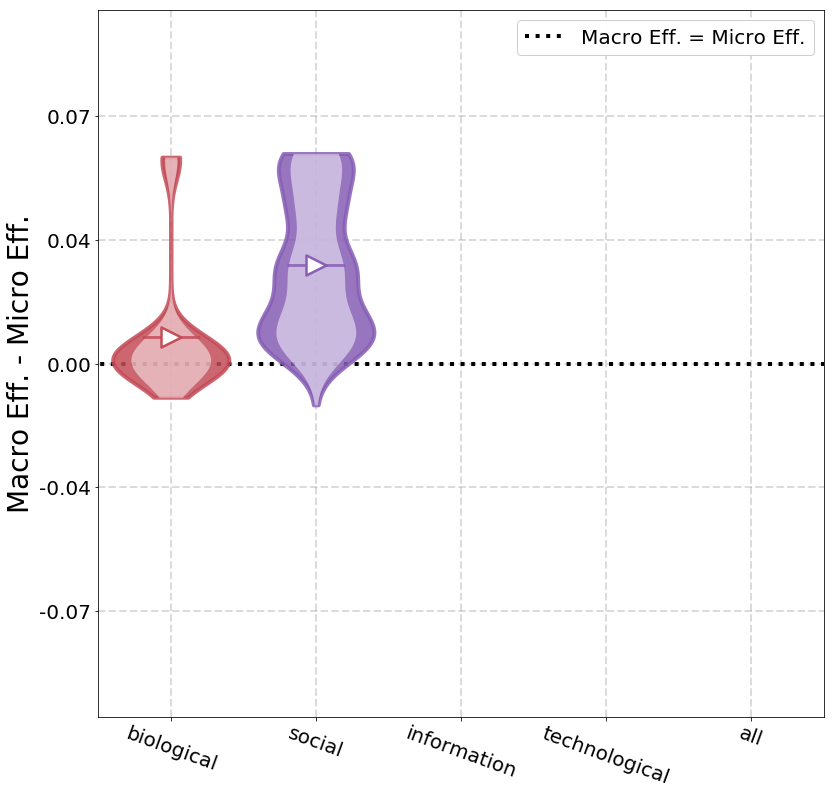

In [118]:
cols = ["#c34b57","#c6b950","#865db4","#64b9b0"]

plt.rc('axes', axisbelow=True)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(13, 13))

plt.hlines(0, 0, 6, linestyle=":", zorder=1, linewidth=4.0, label='Macro Eff. = Micro Eff.')

############
i=0
parts = ax.violinplot(bio, positions=[i+1], showmeans=False, 
                      showmedians=False, showextrema=False, widths=0.8)
pc = parts['bodies'][0]
pc.set_edgecolor(cols[i])
pc.set_facecolor(cols[i])
pc.set_alpha(0.85)
pc.set_linewidth(4.0)
parts = ax.violinplot(bio, positions=[i+1], showmeans=False, 
                      showmedians=False, showextrema=False, widths=0.55)
pc = parts['bodies'][0]
pc.set_edgecolor(cols[i])
pc.set_facecolor('w')
pc.set_alpha(0.5)
pc.set_linewidth(0.0)
plt.hlines(np.mean(bio), [i+0.8], [i+1.2], colors=cols[i], zorder=1, linewidth=3, alpha=0.8)
plt.scatter([i+1], [np.mean(bio)], marker='>', s=400, facecolor='w', 
            edgecolors=cols[i], linewidth=2.5, alpha=0.98)
############

############
i=1
parts = ax.violinplot(soc, positions=[i+1], showmeans=False, 
                      showmedians=False, showextrema=False, widths=0.8)
pc = parts['bodies'][0]
pc.set_edgecolor(cols[2])
pc.set_facecolor(cols[2])
pc.set_alpha(0.85)
pc.set_linewidth(4.0)
parts = ax.violinplot(soc, positions=[i+1], showmeans=False, 
                      showmedians=False, showextrema=False, widths=0.55)
pc = parts['bodies'][0]
pc.set_edgecolor(cols[2])
pc.set_facecolor('w')
pc.set_alpha(0.5)
pc.set_linewidth(0.0)
plt.hlines(np.mean(soc), [i+0.8], [i+1.2], colors=cols[2], zorder=1, linewidth=3, alpha=0.8)
plt.scatter([i+1], [np.mean(soc)], marker='>', s=400, facecolor='w', 
            edgecolors=cols[2], linewidth=2.5, alpha=0.98)
############



    
ax.set_ylabel('Macro Eff. - Micro Eff.', fontsize=28)
# ax.set_xlabel('Network', fontsize=28)
yticks = np.linspace(-0.07,0.07,5)
xticks = ['biological', 'social', 'information', 'technological', 'all']

ax.set_xticks(np.linspace(1, len(xticks)+1, len(xticks)+1))
ax.set_xticklabels(xticks, fontsize=20, rotation=340)
ax.set_yticks(yticks)
ax.set_yticklabels(["%.2f"%i for i in yticks], fontsize=20)
ax.grid(True, linestyle='--', linewidth=2.0, color='#999999', alpha=0.35)

# ax.text(0.55,-.030,"Random", fontsize=20, color='k')
# ax.text(0.72,-.065,"Tree", fontsize=20, color='k')
# ax.text(4.02,-.030,"Barabási-Albert", fontsize=20, color='k')
# ax.text(4.42,-.065,"Network", fontsize=20, color='k')
# ax.text(8.40,-.065,"Star-like \nNetwork", fontsize=20, color='k')
# ax.text(0.55,-.030,"Random", fontsize=20, color=cols[0], alpha=0.95)
# ax.text(0.72,-.065,"Tree", fontsize=20, color=cols[0], alpha=0.95)
# ax.text(4.02,-.030,"Barabási-Albert", fontsize=20, color=cols[4], alpha=0.95)
# ax.text(4.42,-.065,"Network", fontsize=20, color=cols[4], alpha=0.9)
# ax.text(8.40,-.065,"Star-like \nNetwork", fontsize=20, color=cols[8], alpha=0.9)

leg1 = ax.legend(fontsize=20, framealpha=0.95)
ax.set_ylim(-0.1, 0.1)
ax.set_xlim(0.5, 5.5)

# plt.savefig("../figs/pngs/CausalEmergence_violin_Konect_typetest.png", dpi=425, bbox_inches='tight')
# plt.savefig("../figs/pdfs/CausalEmergence_violin_Konect_typetest.pdf", bbox_inches='tight')
plt.show()

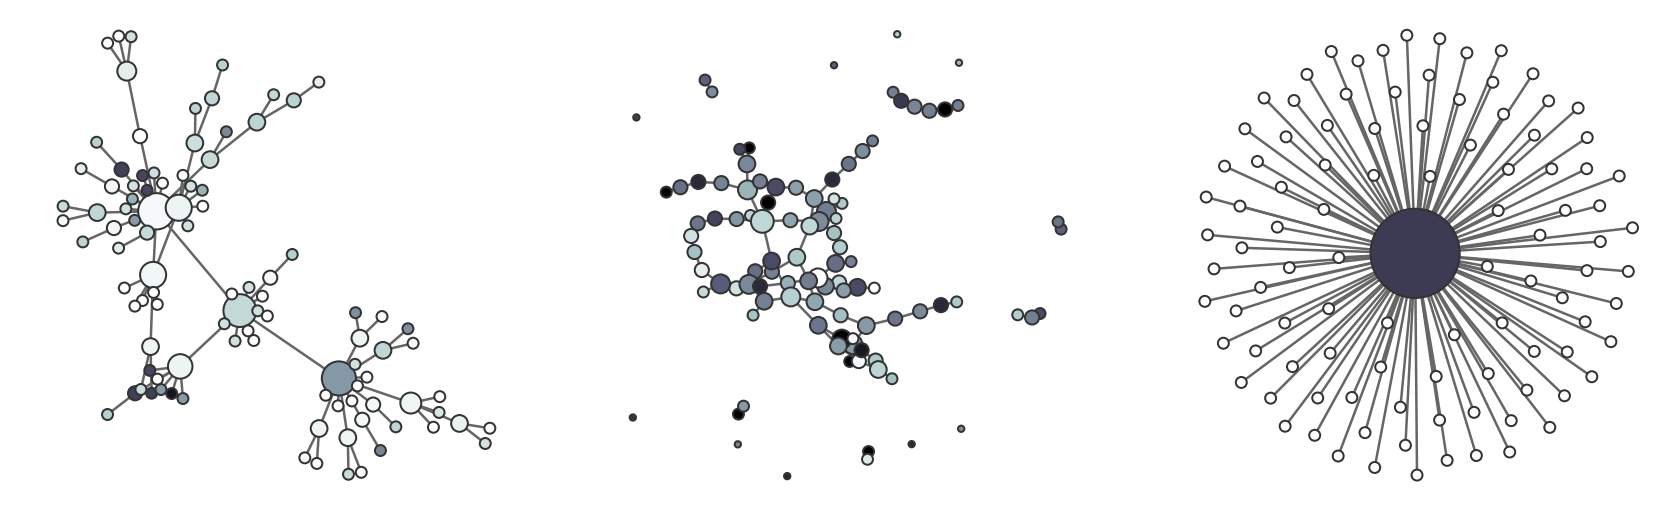

In [443]:
valsb = np.array(list(nx.get_node_attributes(Gbara, 'max_EI_change').values()))
valse = np.array(list(nx.get_node_attributes(Gerdo, 'max_EI_change').values()))
valss = np.array(list(nx.get_node_attributes(Gstar, 'max_EI_change').values()))
maxval = max([max(valsb), max(valse), max(valss)])
minval = np.abs(min([min(valsb), min(valse), min(valss)]))

mu = 40
fig, (ax0, ax1, ax2) = plt.subplots(1,3,figsize=(29,9))
posb = nx.spring_layout(Gbara)
valsb = valsb + minval
ncb = plt.cm.bone(valsb/max(valsb))
ns = np.array(list(dict(Gbara.degree()).values()))+1
nx.draw_networkx_nodes(Gbara, pos=posb, node_color=ncb, node_size=ns*mu, 
                       linewidths=2.0, ax=ax0).set_edgecolor('#333333')
nx.draw_networkx_edges(nx.to_undirected(Gbara), pos=posb, edge_color='#666666', width=2.5, ax=ax0)
ax0.set_axis_off()

pose = nx.spring_layout(Gerdo)
valse = valse + minval
nce = plt.cm.bone(valse/max(valse))
ns = np.array(list(dict(Gerdo.degree()).values()))+1
nx.draw_networkx_nodes(Gerdo, pos=pose, node_color=nce, node_size=ns*mu, 
                       linewidths=2.0, ax=ax1).set_edgecolor('#333333')
nx.draw_networkx_edges(nx.to_undirected(Gerdo), pos=pose, edge_color='#666666', width=2.5, ax=ax1)
ax1.set_axis_off()

poss = nx.spring_layout(Gstar)
valss = valss + minval
ncs = plt.cm.bone(valss/max(valss))
ns = np.array(list(dict(Gstar.degree()).values()))+1
nx.draw_networkx_nodes(Gstar, pos=poss, node_color=ncs, node_size=ns*mu, 
                       linewidths=2.0, ax=ax2).set_edgecolor('#333333')
nx.draw_networkx_edges(nx.to_undirected(Gstar), pos=poss, edge_color='#666666', width=2.5, ax=ax2)
ax2.set_axis_off()

plt.show()

In [154]:
valsb = np.array(list(nx.get_node_attributes(Gbara, 'mean_EI_change').values()))
valse = np.array(list(nx.get_node_attributes(Gerdo, 'mean_EI_change').values()))
valss = np.array(list(nx.get_node_attributes(Gstar, 'mean_EI_change').values()))
maxval = max([max(valsb), max(valse), max(valss)])
minval = np.abs(min([min(valsb), min(valse), min(valss)]))

mu = 40
fig, (ax0, ax1, ax2) = plt.subplots(1,3,figsize=(29,9))
posb = nx.spring_layout(Gbara)
valsb = valsb + minval
ncb = plt.cm.bone(valsb/max(valsb))
ns = np.array(list(dict(Gbara.degree()).values()))+1
nx.draw_networkx_nodes(Gbara, pos=posb, node_color=ncb, node_size=ns*mu, 
                       linewidths=2.0, ax=ax0).set_edgecolor('#333333')
nx.draw_networkx_edges(nx.to_undirected(Gbara), pos=posb, edge_color='#666666', width=2.5, ax=ax0)
ax0.set_axis_off()

pose = nx.spring_layout(Gerdo)
valse = valse + minval
nce = plt.cm.bone(valse/max(valse))
ns = np.array(list(dict(Gerdo.degree()).values()))+1
nx.draw_networkx_nodes(Gerdo, pos=pose, node_color=nce, node_size=ns*mu, 
                       linewidths=2.0, ax=ax1).set_edgecolor('#333333')
nx.draw_networkx_edges(nx.to_undirected(Gerdo), pos=pose, edge_color='#666666', width=2.5, ax=ax1)
ax1.set_axis_off()

poss = nx.spring_layout(Gstar)
valss = valss + minval
ncs = plt.cm.bone(valss/max(valss))
ns = np.array(list(dict(Gstar.degree()).values()))+1
nx.draw_networkx_nodes(Gstar, pos=poss, node_color=ncs, node_size=ns*mu, 
                       linewidths=2.0, ax=ax2).set_edgecolor('#333333')
nx.draw_networkx_edges(nx.to_undirected(Gstar), pos=poss, edge_color='#666666', width=2.5, ax=ax2)
ax2.set_axis_off()

plt.show()

NameError: name 'Gbara' is not defined

In [256]:
# ffn = '../../../../../Downloads/power-bcspwr09/power-bcspwr09.mtx'
ffn = '../../../../../Downloads/power-bcspwr10/power-bcspwr10.mtx'
# with open(ffn, 'rb') as f:
#     ncols = len(next(f).split(' '))

ncols=3
x = np.genfromtxt(ffn, delimiter=' ', dtype=None, names=True, skip_header=13, usecols=(0,1))
                  
# y is a view of x, so it will not require much additional memory
# y = x.view(dtype=('int', len(x.dtype)))

# G = nx.from_numpy_matrix(y)
# G = nx.relabel_nodes(G, dict(zip(range(ncols-1), labels)))

# print(G.edges(data=True))

In [257]:
xx = pd.DataFrame(x)
xx.columns = ['source','target']

# xx = xx.append(pd.DataFrame({'source':[662],'target':[662],'weight':[1568]}))

In [258]:
xx

,source,target
0,1,1
1,1245,1
2,2319,1
3,4939,1
4,2,2
5,3036,2
6,3,3
7,2085,3
8,4,4
9,238,4


In [260]:
# GG = nx.convert_node_labels_to_integers(GG)

In [261]:
p0=0.0

In [264]:
# ecoeverglades_dict = {'names':'Everglade Food Web', 
#               'types':'trophic', 
#               'nodes':GG.number_of_nodes(), 
#               'edges':GG.number_of_edges(), 
#               'effin':get_ei(GG,p0), 
#               'effec':get_ei(GG,p0)/np.log2(GG.number_of_nodes()), 
#               'deter':get_determinism(GG,p0), 
#               'degen':get_degeneracy(GG,p0),
#               'color':"#666666", 
#               'num':77, 
#               'newty':'biological', 
#               'newco':'#c34b57'}
# ecostmarks_dict = {'names':'St. Marks Food Web', 
#               'types':'trophic', 
#               'nodes':GG.number_of_nodes(), 
#               'edges':GG.number_of_edges(), 
#               'effin':get_ei(GG,p0), 
#               'effec':get_ei(GG,p0)/np.log2(GG.number_of_nodes()), 
#               'deter':get_determinism(GG,p0), 
#               'degen':get_degeneracy(GG,p0),
#               'color':"#666666", 
#               'num':78, 
#               'newty':'biological', 
#               'newco':'#c34b57'}
# ecomangwet_dict = {'names':'Mangwet Food Web', 
#               'types':'trophic', 
#               'nodes':GG.number_of_nodes(), 
#               'edges':GG.number_of_edges(), 
#               'effin':get_ei(GG,p0), 
#               'effec':get_ei(GG,p0)/np.log2(GG.number_of_nodes()), 
#               'deter':get_determinism(GG,p0), 
#               'degen':get_degeneracy(GG,p0),
#               'color':"#666666", 
#               'num':79, 
#               'newty':'biological', 
#               'newco':'#c34b57'}
# internet_as1_dict = {'names':'Internet Autonomous Systems 2', 
#               'types':'computer', 
#               'nodes':GG.number_of_nodes(), 
#               'edges':GG.number_of_edges(), 
#               'effin':get_ei(GG,p0), 
#               'effec':get_ei(GG,p0)/np.log2(GG.number_of_nodes()), 
#               'deter':get_determinism(GG,p0), 
#               'degen':get_degeneracy(GG,p0),
#               'color':"#b8ab51", 
#               'num':80, 
#               'newty':'technological', 
#               'newco':'#64b9b0'}
# pgp_dict = {'names':'PGP System', 
#               'types':'computer', 
#               'nodes':GG.number_of_nodes(), 
#               'edges':GG.number_of_edges(), 
#               'effin':get_ei(GG,p0), 
#               'effec':get_ei(GG,p0)/np.log2(GG.number_of_nodes()), 
#               'deter':get_determinism(GG,p0), 
#               'degen':get_degeneracy(GG,p0),
#               'color':"#b8ab51", 
#               'num':81, 
#               'newty':'technological', 
#               'newco':'#64b9b0'}
# WHOIS_dict = {'names':'WHOIS System', 
#               'types':'computer', 
#               'nodes':GG.number_of_nodes(), 
#               'edges':GG.number_of_edges(), 
#               'effin':get_ei(GG,p0), 
#               'effec':get_ei(GG,p0)/np.log2(GG.number_of_nodes()), 
#               'deter':get_determinism(GG,p0), 
#               'degen':get_degeneracy(GG,p0),
#               'color':"#b8ab51", 
#               'num':82, 
#               'newty':'technological', 
#               'newco':'#64b9b0'}
# RoutersRF_dict = {'names':'Routers RF', 
#               'types':'computer', 
#               'nodes':GG.number_of_nodes(), 
#               'edges':GG.number_of_edges(), 
#               'effin':get_ei(GG,p0), 
#               'effec':get_ei(GG,p0)/np.log2(GG.number_of_nodes()), 
#               'deter':get_determinism(GG,p0), 
#               'degen':get_degeneracy(GG,p0),
#               'color':"#b8ab51", 
#               'num':83, 
#               'newty':'technological', 
#               'newco':'#64b9b0'}
# powereris_dict = {'names':'BSC Power 09', 
#               'types':'infrastructure', 
#               'nodes':GG.number_of_nodes(), 
#               'edges':GG.number_of_edges(), 
#               'effin':get_ei(GG,p0), 
#               'effec':get_ei(GG,p0)/np.log2(GG.number_of_nodes()), 
#               'deter':get_determinism(GG,p0), 
#               'degen':get_degeneracy(GG,p0),
#               'color':"#786bdb", 
#               'num':84, 
#               'newty':'technological', 
#               'newco':'#64b9b0'}
powereris_dict = {'names':'BSC Power 10', 
              'types':'infrastructure', 
              'nodes':GG.number_of_nodes(), 
              'edges':GG.number_of_edges(), 
              'effin':get_ei(GG,p0), 
              'effec':get_ei(GG,p0)/np.log2(GG.number_of_nodes()), 
              'deter':get_determinism(GG,p0), 
              'degen':get_degeneracy(GG,p0),
              'color':"#786bdb", 
              'num':86, 
              'newty':'technological', 
              'newco':'#64b9b0'}

In [265]:
powereris_dict

{'color': '#786bdb',
 'degen': 0.26616528801108252,
 'deter': 11.365038946064004,
 'edges': 13571,
 'effec': 0.89711235315038362,
 'effin': 11.098873658052952,
 'names': 'BSC Power 10',
 'newco': '#64b9b0',
 'newty': 'technological',
 'nodes': 5300,
 'num': 86,
 'types': 'infrastructure'}

In [183]:
enron_dict = {'names': 'Enron Emails', 'types': 'communication', 'nodes': 87273, 'edges': 321918, 'effin': 9.45082342737, 'effec': 0.57580459149689722, 'deter': 14.853130630766957, 'degen': 5.4023072033994257, 'color': '#daaa32', 'num': 76, 'newty': 'social', 'newco': '#865db4'}

In [184]:
enron_dict, ecoeverglades_dict, ecostmarks_dict, ecomangwet_dict, 

({'color': '#daaa32',
  'degen': 5.402307203399426,
  'deter': 14.853130630766957,
  'edges': 321918,
  'effec': 0.5758045914968972,
  'effin': 9.45082342737,
  'names': 'Enron Emails',
  'newco': '#865db4',
  'newty': 'social',
  'nodes': 87273,
  'num': 76,
  'types': 'communication'},
 {'color': '#666666',
  'degen': 3.7420799421263427,
  'deter': 4.3941779775930669,
  'edges': 915,
  'effec': 0.10675213631061756,
  'effin': 0.65209803546672418,
  'names': 'Everglade Food Web',
  'newco': '#c34b57',
  'newty': 'biological',
  'nodes': 69,
  'num': 77,
  'types': 'trophic'},
 {'color': '#666666',
  'degen': 2.8365639039688202,
  'deter': 4.2301169547565962,
  'edges': 355,
  'effec': 0.24215122367967915,
  'effin': 1.393553050787776,
  'names': 'St. Marks Food Web',
  'newco': '#c34b57',
  'newty': 'biological',
  'nodes': 54,
  'num': 78,
  'types': 'trophic'},
 {'color': '#666666',
  'degen': 4.0658487224702853,
  'deter': 5.0916855236632736,
  'edges': 1491,
  'effec': 0.155431870